In [1]:
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
import nltk
from nltk.tokenize import word_tokenize


# Sklearn clustering and encoding 
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from sklearn.metrics import adjusted_rand_score
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.colors as mcolors


In [2]:
!python --version

# Version des bibliothèques utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))



Python 3.11.5pandas - 2.0.3
numpy - 1.26.3
seaborn - 0.12.2
nltk - 3.8.1
gensim - 4.3.0



In [3]:
df=  pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')
df.head(2)

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   

        product_rating       overall_rating     brand  \
0  No rating available  No rating available  Elegance   
1  No rating available  No rating available  Sathiyas   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [5]:
df.sample(5)

uniq_id            crawl_timestamp  \
226  f39a2cce8929f5b44087d688995994e4  2015-12-01 12:40:44 +0000   
785  29d7a1b4d4f658fc3082905f65e1b009  2015-12-12 11:46:53 +0000   
379  534d9c3ae2342df2f4f9233622f90711  2015-12-01 06:13:00 +0000   
271  9906d8f74589c452b00f2b5642a63c5f  2015-12-01 12:40:44 +0000   
433  32f24a4303050f500dec7cb3608fe089  2016-03-11 06:55:07 +0000   

                                           product_url  \
226  http://www.flipkart.com/tiedribbons-love-mom-g...   
785  http://www.flipkart.com/funcart-frolic-birthda...   
379  http://www.flipkart.com/netgear-ac-750-wi-fi-r...   
271  http://www.flipkart.com/s-c-handicrafts-showpi...   
433  http://www.flipkart.com/smartpro-19-5v-3-9a-re...   

                                          product_name  \
226  Tiedribbons We Love Mom With Green Background ...   
785      Funcart Frolic Birthday  - Food Grade Plastic   
379                Netgear AC 750 Wi-Fi Range Extender   
271                S C Handicrafts Showpiece  -  40 cm   
433  Smartpro 19.5v,3.9a Replacement Charger for Va...   

                                 product_category_tree               pid  \
226  ["Home Decor & Festive Needs >> Showpieces >> ...  SHIE6ZSBWP9DTDHZ   
785  ["Baby Care >> Feeding & Nursing >> Utensils >...  FDUE6ZHHR9AAKU2B   
379  ["Computers >> Network Components >> Routers >...  RTRDYKU6F2GVR3CR   
271  ["Home Decor & Festive Needs >> Showpieces >> ...  SHIE2QTSMSXF9QAH   
433  ["Computers >> Laptop Accessories >> Adapters ...  ACCEGZ6BY4ZPBWWV   

     retail_price  discounted_price                                 image  \
226        1599.0             699.0  f39a2cce8929f5b44087d688995994e4.jpg   
785         206.0             154.0  29d7a1b4d4f658fc3082905f65e1b009.jpg   
379        6570.0            5555.0  534d9c3ae2342df2f4f9233622f90711.jpg   
271        9500.0            8900.0  9906d8f74589c452b00f2b5642a63c5f.jpg   
433        1499.0             539.0  32f24a4303050f500dec7cb3608fe089.jpg   

     is_FK_Advantage_product  \
226                    False   
785                    False   
379                    False   
271                    False   
433                    False   

                                           description       product_rating  \
226  Buy Tiedribbons We Love Mom With Green Backgro...  No rating available   
785  Flipkart.com is offering Small Funcart Frolic ...  No rating available   
379  Buy Netgear AC 750 Wi-Fi Range Extender only f...                  3.5   
271  Buy S C Handicrafts Showpiece  -  40 cm for Rs...  No rating available   
433  Key Features of Smartpro 19.5v,3.9a Replacemen...  No rating available   

          overall_rating            brand  \
226  No rating available      Tiedribbons   
785  No rating available          Funcart   
379                  3.5          Netgear   
271  No rating available  S C Handicrafts   
433  No rating available         Smartpro   

                                product_specifications  
226  {"product_specification"=>[{"key"=>"Brand", "v...  
785  {"product_specification"=>[{"key"=>"Brand", "v...  
379  {"product_specification"=>[{"key"=>"Encryption...  
271  {"product_specification"=>[{"key"=>"Brand", "v...  
433  {"product_specification"=>[{"key"=>"Brand", "v...

In [6]:
df.dtypes.value_counts()

object     12
float64     2
bool        1
Name: count, dtype: int64

In [7]:
df.isna().sum()

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

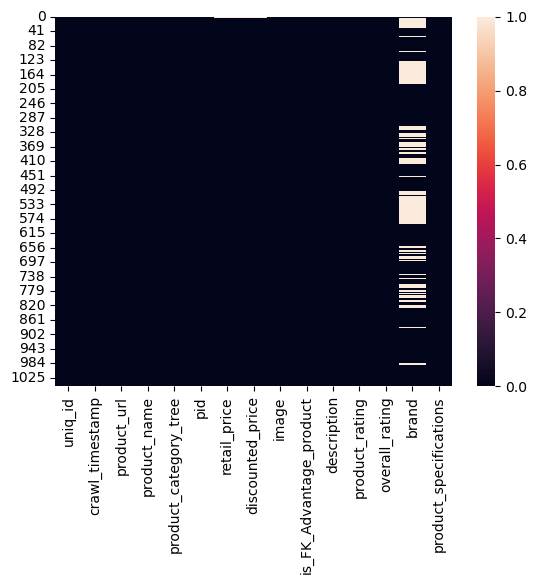

In [8]:
sns.heatmap(df.isnull());

### Traitement de la fonctionnalité "product_category_tree"

In [9]:
df.duplicated(subset="product_category_tree").sum()

408

In [10]:
df_cat = df.groupby('product_category_tree')
df_cat.first()

uniq_id  \
product_category_tree                                                                  
["Baby Care >> Baby & Kids Gifts >> Decorations...  6325bf868b9040a0599f257aba42e9e0   
["Baby Care >> Baby & Kids Gifts >> Photo Frame...  fd10586bf7f01bc57e0c5364d4b2c3f7   
["Baby Care >> Baby & Kids Gifts >> Photo Frame...  6eabdbbbffdfae86c3c5177ba0f96ea7   
["Baby Care >> Baby & Kids Gifts >> Photo Frame...  d06bb04b096c77dc3302eaf2db336f96   
["Baby Care >> Baby & Kids Gifts >> Photo Frame...  f79c9db3abd7faca714c92aeba9b6728   
...                                                                              ...   
["Watches >> Wrist Watches >> Yves Bertelin Wri...  4d2e9f36823bad0f6fe8c6b19bb92bdb   
["Watches >> Wrist Watches >> fastrack Wrist Wa...  653826cd53f1d9e2c086c0ac7846ef70   
["Watches >> Wrist Watches >> palito Wrist Watc...  64a9d0488652194fd8e879d5e6dc8015   
["Watches >> Wrist Watches >> palito Wrist Watc...  009099b1f6e1e8f893ec29a7023153c4   
["Watches >> Wrist Watches >> palito Wrist Watc...  113783ce1db999778b5a4bd374e61209   

                                                              crawl_timestamp  \
product_category_tree                                                           
["Baby Care >> Baby & Kids Gifts >> Decorations...  2016-03-03 11:29:08 +0000   
["Baby Care >> Baby & Kids Gifts >> Photo Frame...  2015-12-31 09:19:31 +0000   
["Baby Care >> Baby & Kids Gifts >> Photo Frame...  2015-12-31 09:19:31 +0000   
["Baby Care >> Baby & Kids Gifts >> Photo Frame...  2015-12-31 09:19:31 +0000   
["Baby Care >> Baby & Kids Gifts >> Photo Frame...  2015-12-31 09:19:31 +0000   
...                                                                       ...   
["Watches >> Wrist Watches >> Yves Bertelin Wri...  2016-04-24 18:34:50 +0000   
["Watches >> Wrist Watches >> fastrack Wrist Wa...  2015-12-04 07:25:36 +0000   
["Watches >> Wrist Watches >> palito Wrist Watc...  2016-04-24 18:34:50 +0000   
["Watches >> Wrist Watches >> palito Wrist Watc...  2016-04-24 18:34:50 +0000   
["Watches >> Wrist Watches >> palito Wrist Watc...  2016-04-24 18:34:50 +0000   

                                                                                          product_url  \
product_category_tree                                                                                   
["Baby Care >> Baby & Kids Gifts >> Decorations...  http://www.flipkart.com/doraemon-gift-family-c...   
["Baby Care >> Baby & Kids Gifts >> Photo Frame...  http://www.flipkart.com/cocovey-metal-photo-fr...   
["Baby Care >> Baby & Kids Gifts >> Photo Frame...  http://www.flipkart.com/indha-craft-cloth-phot...   
["Baby Care >> Baby & Kids Gifts >> Photo Frame...  http://www.flipkart.com/mh-mdf-photo-frame/p/i...   
["Baby Care >> Baby & Kids Gifts >> Photo Frame...  http://www.flipkart.com/wood-beauty-photo-fram...   
...                                                                                               ...   
["Watches >> Wrist Watches >> Yves Bertelin Wri...  http://www.flipkart.com/yves-bertelin-ybscr557...   
["Watches >> Wrist Watches >> fastrack Wrist Wa...  http://www.flipkart.com/fastrack-38015pl01-ana...   
["Watches >> Wrist Watches >> palito Wrist Watc...  http://www.flipkart.com/palito-plo-149-analog-...   
["Watches >> Wrist Watches >> palito Wrist Watc...  http://www.flipkart.com/palito-plo-166-analog-...   
["Watches >> Wrist Watches >> palito Wrist Watc...  http://www.flipkart.com/palito-plo-169-analog-...   

                                                                                         product_name  \
product_category_tree                                                                                   
["Baby Care >> Baby & Kids Gifts >> Decorations...  Doraemon Gift Family Ceramic Coffee Mug Multic...   
["Baby Care >> Baby & Kids Gifts >> Photo Frame...                          Cocovey Metal Photo Frame   
["Baby Care >> Baby & Kids Gifts >> Photo Frame...                      Indha Craft Cloth Ph

In [11]:
#Diviser le contenu de la colonne sur '>>' et récupérer le premier élément = la catégorie principale du produit
df['category'] = df['product_category_tree'].str.split('>>').str.get(0).str.strip()

# Suppression de la ponctuation indésirable de la colonne de catégorie
df['category'] = df['category'].str.extract(r'^\["([^"]+)')

In [12]:
# Real number of product categories 
category_count = df['category'].value_counts()

In [13]:
category_count 

category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

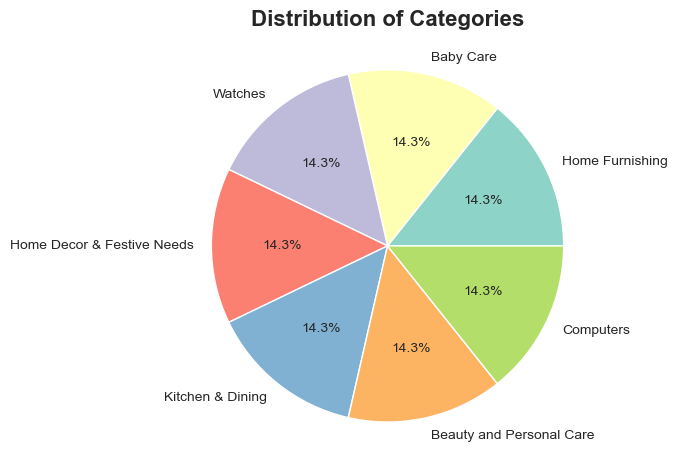

In [14]:
# La distribution par categorie
custom_colors = sns.color_palette('Set3', len(category_count))
plt.figure(figsize=(5, 5))
sns.set_style("whitegrid")
plt.pie(category_count, labels=category_count.index, autopct='%1.1f%%', colors=custom_colors)
plt.title('Distribution of Categories',  fontsize=16, fontweight='bold', pad=20)
plt.axis('equal') 

plt.show()

Il y a sept grandes catégories de produits

## Pre traitement

## Exploration des données


In [15]:
df

uniq_id            crawl_timestamp  \
0     55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1     7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2     64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3     d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4     6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   
...                                ...                        ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc  2015-12-01 10:15:43 +0000   
1046  fd6cbcc22efb6b761bd564c28928483c  2015-12-01 10:15:43 +0000   
1047  5912e037d12774bb73a2048f35a00009  2015-12-01 10:15:43 +0000   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6  2015-12-01 10:15:43 +0000   
1049  f2f027ad6a6df617c9f125173da71e44  2015-12-01 10:15:43 +0000   

                                            product_url  \
0     http://www.flipkart.com/elegance-polyester-mul...   
1     http://www.flipkart.com/sathiyas-cotton-bath-t...   
2     http://www.flipkart.com/eurospa-cotton-terry-f...   
3     http://www.flipkart.com/santosh-royal-fashion-...   
4     http://www.flipkart.com/jaipur-print-cotton-fl...   
...                                                 ...   
1045  http://www.flipkart.com/oren-empower-extra-lar...   
1046  http://www.flipkart.com/wallmantra-large-vinyl...   
1047  http://www.flipkart.com/uberlyfe-extra-large-p...   
1048  http://www.flipkart.com/wallmantra-medium-viny...   
1049  http://www.flipkart.com/uberlyfe-large-vinyl-s...   

                                           product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                  product_category_tree               pid  \
0     ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   
...                                                 ...               ...   
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE88ZGTX65GH4V   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZD5GDCVQ   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE5UVGW2JWVWCT   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZGFD3RCE   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE2ZEPACRQJKH7   

      retail_price  discounted_price                                 image  \
0           1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1            600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2              NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3           2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4           2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   
...            ...               ...                                   ...   
1045        1399.0             999.0  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046        4930.0            1896.0  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047        4500.0            1449.0  5912e037d12774bb73a2048f35a00009.jpg   
1048        3465.0            1333.0  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1

In [16]:
df_t = df 
df_t.shape

(1050, 16)

In [17]:
df.description.apply(lambda i : len(i))

0       1420
1        444
2       1258
3        858
4       1197
        ... 
1045    2432
1046    1660
1047     262
1048     210
1049     187
Name: description, Length: 1050, dtype: int64

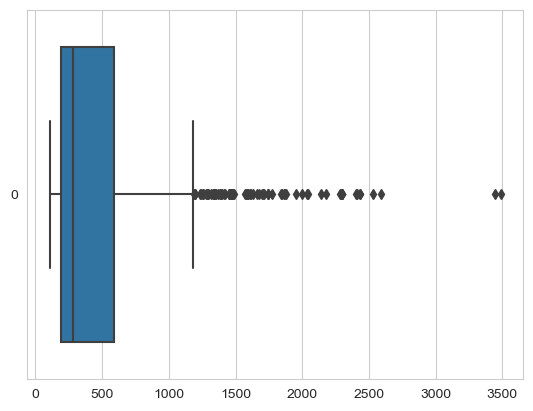

In [18]:
tmp = df.description.str.len()
sns.boxplot(tmp, orient='h');

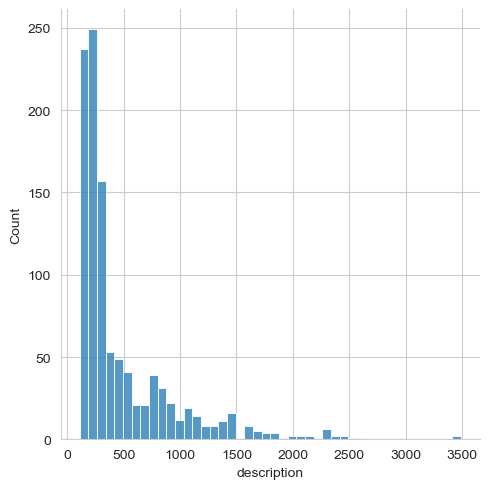

In [19]:
sns.displot(tmp);

In [20]:
df_long = df["_lon_desc"] = tmp
df_long.head(10)

0    1420
1     444
2    1258
3     858
4    1197
5     275
6     268
7     817
8     410
9     430
Name: description, dtype: int64

### Exploration du corpus et des documents

In [21]:
df.head(10)

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   
5  893aa5ed55f7cff2eccea7758d7a86bd  2015-12-04 07:25:36 +0000   
6  f355cc1ccb08bd0d283ed979b7ee7515  2015-12-04 07:25:36 +0000   
7  dd0e3470a7e6ed76fd69c2da27721041  2015-12-04 07:25:36 +0000   
8  41384da51732c0b4df3de8f395714fbb  2015-12-04 07:25:36 +0000   
9  710ed5f2393a4b9e8823aa0029f71f93  2015-12-04 07:25:36 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   
5  http://www.flipkart.com/maserati-time-r8851116...   
6  http://www.flipkart.com/camerii-wm64-elegance-...   
7  http://www.flipkart.com/t-star-uft-tsw-005-bk-...   
8  http://www.flipkart.com/alfajr-wy16b-youth-dig...   
9  http://www.flipkart.com/tag-heuer-cau1116-ba08...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   
5  Maserati Time R8851116001 Analog Watch  - For ...   
6  Camerii WM64 Elegance Analog Watch  - For Men,...   
7  T STAR UFT-TSW-005-BK-BR Analog Watch  - For Boys   
8  Alfajr WY16B Youth Digital Watch  - For Men, Boys   
9  TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   
5  ["Watches >> Wrist Watches >> Maserati Time Wr...  WATEAYAHJ8CUCAYM   
6  ["Watches >> Wrist Watches >> Camerii Wrist Wa...  WATE6Y6D2MZHWGBZ   
7  ["Watches >> Wrist Watches >> T STAR Wrist Wat...  WATECFFVGFZPAD3D   
8  ["Watches >> Wrist Watches >> Alfajr Wrist Wat...  WATECHFU4QGFQEJG   
9  ["Watches >> Wrist Watches >> TAG Heuer Wrist ...  WATEA6UGFGKZKDJC   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   
5       24400.0           24400.0  893aa5ed55f7cff2eccea7758d7a86bd.jpg   
6        1099.0             449.0  f355cc1ccb08bd0d283ed979b7ee7515.jpg   
7         999.0             399.0  dd0e3470a7e6ed76fd69c2da27721041.jpg   
8        5495.0            4995.0  41384da51732c0b4df3de8f395714fbb.jpg   
9      107750.0          107750.0  710ed5f2393a4b9e8823aa0029f71f93.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    

In [22]:
df_samp = df.sample(10)
df_samp

uniq_id            crawl_timestamp  \
814  414d2065e1aed847064bcf14538eabc8  2015-12-12 11:46:53 +0000   
878  dc777afc918f513a7253187e00a11948  2015-12-20 08:26:17 +0000   
327  f3ad282dac6ef0e30585a49ac67a322b  2015-12-01 06:13:00 +0000   
603  baa093d149982b010ab72ecbeec6110f  2016-01-07 04:32:43 +0000   
933  037b39bef3db7ccd264c577a0edf0c0a  2016-01-01 13:15:34 +0000   
941  c12fd368ff03f5224b92771824cafb9c  2016-01-01 13:15:34 +0000   
222  922a04084481d4b3275a3f7bb54e90f3  2015-12-01 12:40:44 +0000   
35   81e739c7f3be737152f2e6f520e3494b  2016-01-06 18:20:45 +0000   
791  4676a8f96abb86c5d1dc5b06c7a11d95  2015-12-12 11:46:53 +0000   
711  28401ff0dbc191d34c2f1103e78e082a  2016-01-01 19:37:22 +0000   

                                           product_url  \
814  http://www.flipkart.com/raymond-abstract-doubl...   
878  http://www.flipkart.com/woven-terry-cotton-bat...   
327  http://www.flipkart.com/edimax-br-6428nc/p/itm...   
603  http://www.flipkart.com/kosher-kadhai-1-l/p/it...   
933  http://www.flipkart.com/gift-studios-buddha-st...   
941  http://www.flipkart.com/intellect-bazaar-geome...   
222  http://www.flipkart.com/purpledip-kattle-showp...   
35   http://www.flipkart.com/riva-carpets-cotton-fr...   
791  http://www.flipkart.com/wild-ferns-manuka-hone...   
711  http://www.flipkart.com/frabjous-floral-single...   

                                          product_name  \
814               Raymond Abstract Double Blanket Blue   
878                      Woven Terry Cotton Bath Towel   
327                                   Edimax BR-6428NC   
603                                  Kosher Kadhai 1 L   
933    Gift Studios Buddha Stone Showpiece  -  17.6 cm   
941  The Intellect Bazaar Geometric Single Blanket ...   
222               Purpledip Kattle Showpiece  -  15 cm   
35   Riva Carpets Cotton Free Bath Mat Classic Loop...   
791        Wild Ferns Manuka Honey Intensive Eye Creme   
711  Frabjous Floral Single Quilts & Comforters Mul...   

                                 product_category_tree               pid  \
814  ["Home Furnishing >> Bed Linen >> Blankets, Qu...  BLAEAWABHH3G8ENS   
878        ["Home Furnishing >> Bath Linen >> Towels"]  BTWEBRYFPZQDCGJC   
327  ["Computers >> Network Components >> Routers >...  RTRDZBJ5VAZG7VGC   
603  ["Kitchen & Dining >> Cookware >> Pots & Pans ...  PTPEANCHZADGHSGH   
933  ["Home Decor & Festive Needs >> Table Decor & ...  SHIEBTGD4Y65CCNS   
941  ["Home Furnishing >> Bed Linen >> Blankets, Qu...  BLAEE3YZ4ZGKEWYS   
222  ["Home Decor & Festive Needs >> Showpieces >> ...  SHIEAW8RHVJNER3B   
35      ["Home Furnishing >> Bath Linen >> Bath Mats"]  MATEB88TYRSSX8SH   
791  ["Beauty and Personal Care >> Eye Care >> Wild...  ECMDQBY28WDJQDWA   
711  ["Home Furnishing >> Bed Linen >> Blankets, Qu...  BLAECQTUSHNAFJAG   

     retail_price  discounted_price                                 image  \
814        4999.0            4999.0  414d2065e1aed847064bcf14538eabc8.jpg   
878         799.0             649.0  dc777afc918f513a7253187e00a11948.jpg   
327        3330.0            2000.0  f3ad282dac6ef0e30585a49ac67a322b.jpg   
603         586.0             586.0  baa093d149982b010ab72ecbeec6110f.jpg   
933        1290.0             699.0  037b39bef3db7ccd264c577a0edf0c0a.jpg   
941        1999.0            1299.0  c12fd368ff03f5224b92771824cafb9c.jpg   
222        2999.0            1505.0  922a04084481d4b3275a3f7bb54e90f3.jpg   
35         1799.0            1799.0  81e739c7f3be737152f2e6f520e3494b.jpg   
791        2000.0            2000.0  4676a8f96abb86c5d1dc5b06c7a11d95.jpg   
711        3999.0            1499.0  28401ff0dbc191d34c2f1103e78e082a.jpg   

     is_FK_Advantage_product  \
814                    False   
878                    False   
327                    False   
603                    False   
933                    False   
941                    False   
222                    False   
35                     False   
791                    False  

In [23]:
for idx, ser in df_samp.iterrows():
    id_prod = f": {ser['uniq_id']}\n"
    print( id_prod + ser["description"]+ "..." +"\n\n")

: 414d2065e1aed847064bcf14538eabc8
Buy Raymond Abstract Double Blanket Blue at Rs. 4999 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!...


: dc777afc918f513a7253187e00a11948
Woven Terry Cotton Bath Towel (Bath Towel, Multi Colour)
                         Price: Rs. 649
				
			100% cotton soft bath terry pack of 3 towels
100% cotton soft bath terry pack of 3 towels...


: f3ad282dac6ef0e30585a49ac67a322b
Buy Edimax BR-6428NC only for Rs. 2150 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!...


: baa093d149982b010ab72ecbeec6110f
Buy Kosher Kadhai 1 L for Rs.586 online. Kosher Kadhai 1 L at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee....


: 037b39bef3db7ccd264c577a0edf0c0a
Buy Gift Studios Buddha Stone Showpiece  -  17.6 cm for Rs.699 online. Gift Studios Buddha Stone Showpiece  -  17.6 cm at best prices with FREE shipping & cash on delivery. O

## NPL ( Traitement du Langage Naturel)
### Nettoyage de la fonctionalité "description"
### Bag of word

In [24]:
import re, nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
def cleaned_text(text):
    clean = re.sub("\n"," ",text)
    clean=clean.lower()
    clean=re.sub(r"[~.,%/:;?_&+*=!-]"," ",clean)
    clean=re.sub("[^a-z]"," ",clean)
    clean=clean.lstrip()
    clean=re.sub("\s{2,}"," ",clean)
    return clean
df_t["cleaned_description"]=df_t["description"].apply(cleaned_text)

In [26]:
df_t["cleaned_description"] = df_t["cleaned_description"].apply(lambda x: ' '.join([word for word in x.split() if len(word)>3]))

In [27]:
 df_t["cleaned_description"].head(10)

0    features elegance polyester multicolor abstrac...
1    specifications sathiyas cotton bath towel bath...
2    features eurospa cotton terry face towel size ...
3    features santosh royal fashion cotton printed ...
4    features jaipur print cotton floral king sized...
5    maserati time analog watch boys maserati time ...
6    camerii elegance analog watch boys camerii ele...
7    star analog watch boys price whether your work...
8    alfajr youth digital watch boys alfajr youth d...
9    heuer formula analog watch boys heuer formula ...
Name: cleaned_description, dtype: object

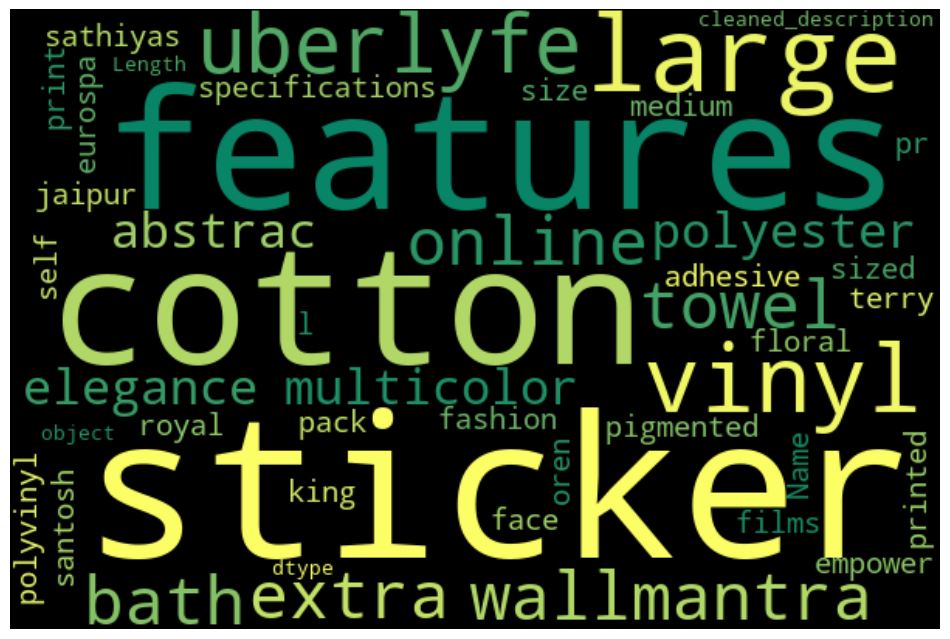

In [28]:
cloud=WordCloud(colormap="summer",width=600,height=400).generate(str(df_t["cleaned_description"]))
fig=plt.figure(figsize=(12,9))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear');

In [29]:
stop=stopwords.words('english')
stop.append("also")
df_t["stop_removed_description"]=df_t["cleaned_description"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [30]:
df_t["tokenized"]=df_t["stop_removed_description"].apply(lambda x: nltk.word_tokenize(x))

In [31]:
df_t["tokenized"]

0       [features, elegance, polyester, multicolor, ab...
1       [specifications, sathiyas, cotton, bath, towel...
2       [features, eurospa, cotton, terry, face, towel...
3       [features, santosh, royal, fashion, cotton, pr...
4       [features, jaipur, print, cotton, floral, king...
                              ...                        
1045    [oren, empower, extra, large, self, adhesive, ...
1046    [wallmantra, large, vinyl, sticker, sticker, p...
1047    [uberlyfe, extra, large, pigmented, polyvinyl,...
1048    [wallmantra, medium, vinyl, sticker, sticker, ...
1049    [uberlyfe, large, vinyl, sticker, online, uber...
Name: tokenized, Length: 1050, dtype: object

### Lemmatization

In [32]:
from nltk.stem import WordNetLemmatizer 

In [33]:
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i,pos='v') for i in text]
    return lem_text
df_t["lemmatized"]=df_t["tokenized"].apply(lambda x: word_lemmatizer(x))
df_t["lemmatize_joined"]=df_t["lemmatized"].apply(lambda x: ' '.join(x))

In [34]:
df_t["lemmatize_joined"].head()

0    feature elegance polyester multicolor abstract...
1    specifications sathiyas cotton bath towel bath...
2    feature eurospa cotton terry face towel size s...
3    feature santosh royal fashion cotton print kin...
4    feature jaipur print cotton floral king size d...
Name: lemmatize_joined, dtype: object

In [35]:
df_t['Nombre de mots après nettoyage'] = df_t['lemmatize_joined'].apply(lambda x:len(str(x).split()))

In [36]:
df_t

uniq_id            crawl_timestamp  \
0     55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1     7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2     64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3     d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4     6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   
...                                ...                        ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc  2015-12-01 10:15:43 +0000   
1046  fd6cbcc22efb6b761bd564c28928483c  2015-12-01 10:15:43 +0000   
1047  5912e037d12774bb73a2048f35a00009  2015-12-01 10:15:43 +0000   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6  2015-12-01 10:15:43 +0000   
1049  f2f027ad6a6df617c9f125173da71e44  2015-12-01 10:15:43 +0000   

                                            product_url  \
0     http://www.flipkart.com/elegance-polyester-mul...   
1     http://www.flipkart.com/sathiyas-cotton-bath-t...   
2     http://www.flipkart.com/eurospa-cotton-terry-f...   
3     http://www.flipkart.com/santosh-royal-fashion-...   
4     http://www.flipkart.com/jaipur-print-cotton-fl...   
...                                                 ...   
1045  http://www.flipkart.com/oren-empower-extra-lar...   
1046  http://www.flipkart.com/wallmantra-large-vinyl...   
1047  http://www.flipkart.com/uberlyfe-extra-large-p...   
1048  http://www.flipkart.com/wallmantra-medium-viny...   
1049  http://www.flipkart.com/uberlyfe-large-vinyl-s...   

                                           product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                  product_category_tree               pid  \
0     ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   
...                                                 ...               ...   
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE88ZGTX65GH4V   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZD5GDCVQ   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE5UVGW2JWVWCT   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZGFD3RCE   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE2ZEPACRQJKH7   

      retail_price  discounted_price                                 image  \
0           1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1            600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2              NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3           2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4           2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   
...            ...               ...                                   ...   
1045        1399.0             999.0  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046        4930.0            1896.0  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047        4500.0            1449.0  5912e037d12774bb73a2048f35a00009.jpg   
1048        3465.0            1333.0  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1

In [37]:
df_t.to_csv('df_t.csv', index=False)

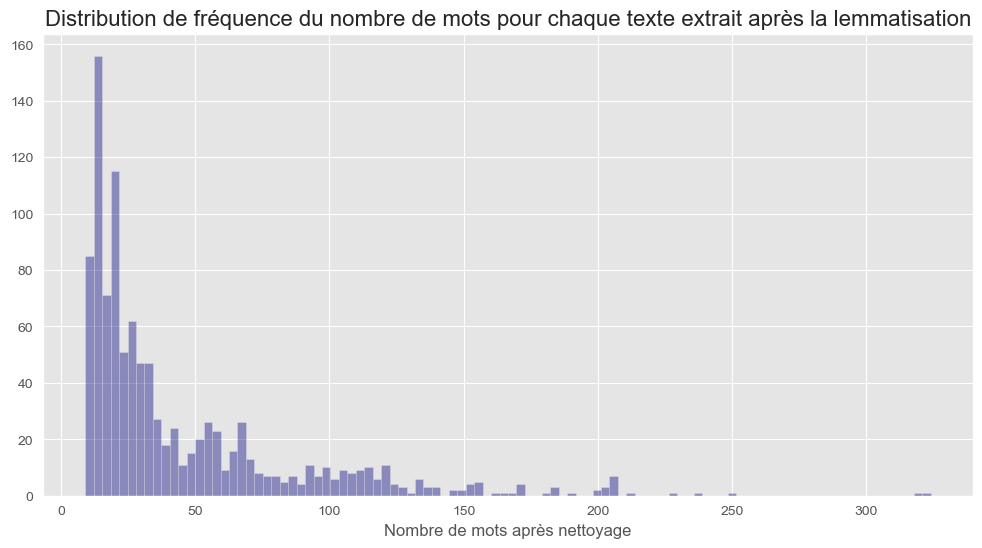

In [38]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(df_t['Nombre de mots après nettoyage'],kde = False, color= "navy", bins = 100)
plt.title("Distribution de fréquence du nombre de mots pour chaque texte extrait après la lemmatisation", size=16);

In [39]:
df_t.drop(df_t[df_t["Nombre de mots après nettoyage"]>300].index, inplace = True)

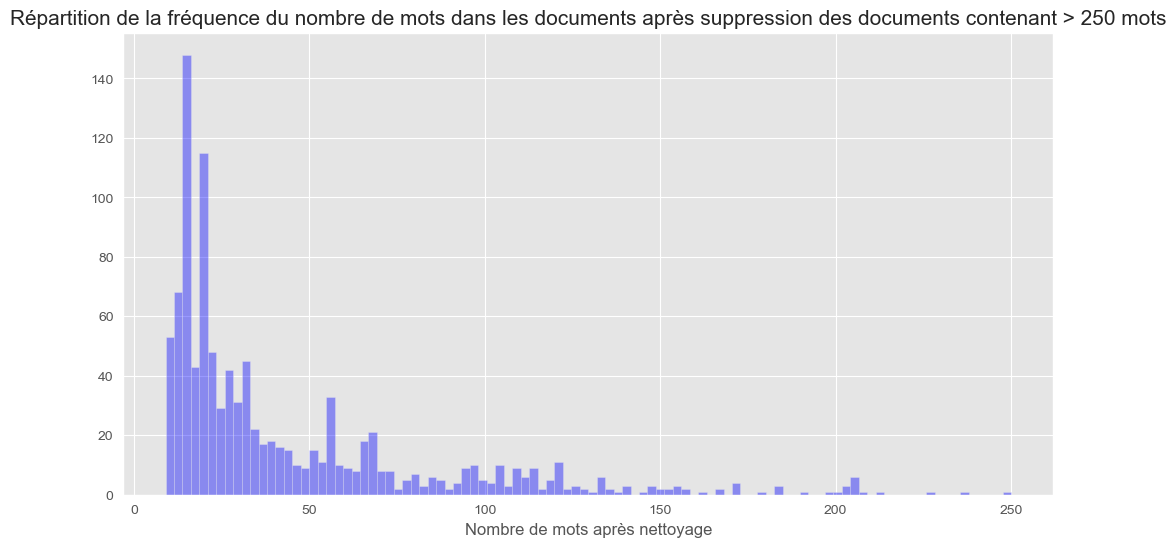

In [40]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(df_t['Nombre de mots après nettoyage'],kde = False, color= "blue", bins = 100)
plt.title("Répartition de la fréquence du nombre de mots dans les documents après suppression des documents contenant > 250 mots", size=15);

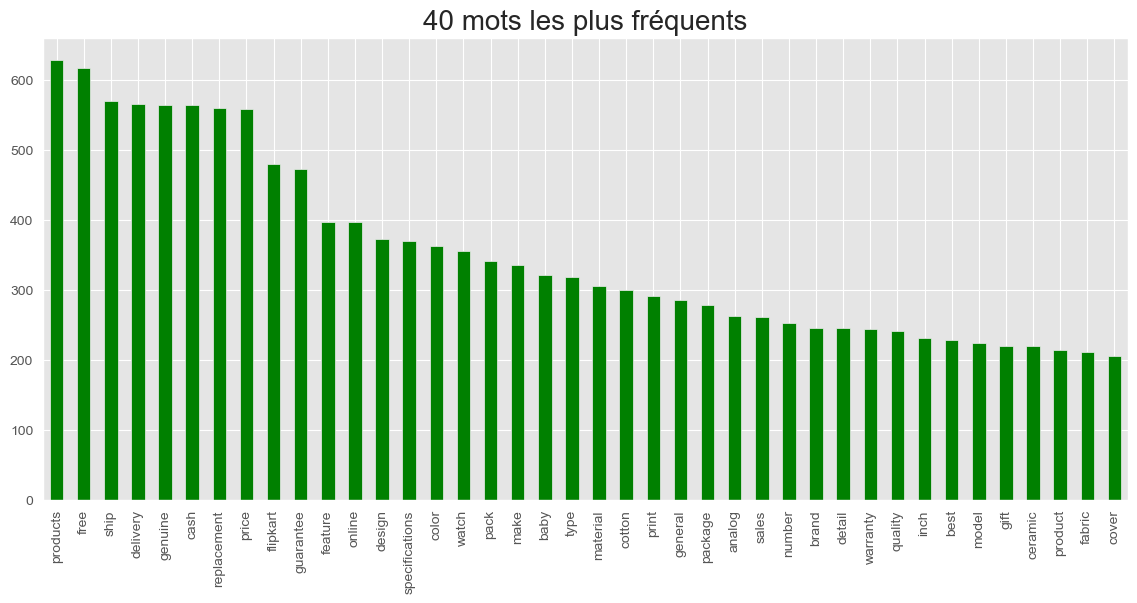

In [41]:
plt.style.use('ggplot')
plt.figure(figsize=(14,6))
freq=pd.Series(" ".join(df_t["lemmatize_joined"]).split()).value_counts()[:40]
freq.plot(kind="bar", color = "green")
plt.title("40 mots les plus fréquents",size=20);

### TF-IDF (Term frequency-inverse document frequency)

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer, BertModel
from gensim.models import Word2Vec
import itertools
import tensorflow as tf


In [43]:
from string import punctuation
from nltk.corpus import stopwords
stopwords_en = set(["a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"])
stopwords_nltk = set(stopwords.words('english'))
stopwords_punct = set(punctuation)
stopwords_combined = set.union(stopwords_en, stopwords_nltk, stopwords_punct)

In [44]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer:
     def __init__(self):
         self.wnl = WordNetLemmatizer()
        
     def __call__(self, doc):
         return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

tfidf = TfidfVectorizer(encoding='utf-8',
                       lowercase=True,
                       tokenizer=LemmaTokenizer(),
                       stop_words=stopwords_combined,
                       )

In [45]:
tfidf = TfidfVectorizer()
 
# get tf-df values
result = tfidf.fit_transform(df_t["lemmatize_joined"])

In [46]:
# display tf-idf values
print('\ntf-idf value:')
print(result)


tf-idf value:
  (0, 2166)	0.027397267146430156
  (0, 398)	0.03865767113749738
  (0, 2502)	0.053225835094828956
  (0, 3066)	0.05332048398105012
  (0, 786)	0.030801184738734194
  (0, 2407)	0.026755542634160086
  (0, 2006)	0.038360859593822946
  (0, 1009)	0.03073075940256852
  (0, 701)	0.026061228758610274
  (0, 1099)	0.07544008473301013
  (0, 2338)	0.03490757378424297
  (0, 2253)	0.06146151880513704
  (0, 3716)	0.025883656959427393
  (0, 435)	0.02694880769348391
  (0, 1499)	0.0239970943529323
  (0, 3343)	0.022401068740301032
  (0, 3467)	0.07544008473301013
  (0, 114)	0.06823988163978455
  (0, 2986)	0.0545098820748413
  (0, 2021)	0.040109475888390124
  (0, 1351)	0.07122823592589668
  (0, 3298)	0.07544008473301013
  (0, 457)	0.04406482531046763
  (0, 2742)	0.03362594985975211
  (0, 3313)	0.06823988163978455
  :	:
  (1046, 949)	0.058886445972381594
  (1046, 554)	0.05895084409734762
  (1046, 3181)	0.058886445972381594
  (1046, 1434)	0.05706677930788321
  (1046, 1592)	0.06550034644260636
  (

In [47]:
# Converting each sequence of words into a single string
corpus = df_t['lemmatize_joined']

# Defining the vectorizer
vectorizer = TfidfVectorizer()

# Fitting it to the string 
vectorizer.fit(corpus)

# Transforming the corpus into a TF-IDF matrix
tfidf_matrix = vectorizer.transform(corpus)

# Converting the TF-IDF matrix to a df
feature_names = vectorizer.get_feature_names_out()
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

In [48]:
df_tfidf

aapno  aari  aarika  abide  abilities  ability  abkl  able  abroad  \
0       0.0   0.0     0.0    0.0        0.0      0.0   0.0   0.0     0.0   
1       0.0   0.0     0.0    0.0        0.0      0.0   0.0   0.0     0.0   
2       0.0   0.0     0.0    0.0        0.0      0.0   0.0   0.0     0.0   
3       0.0   0.0     0.0    0.0        0.0      0.0   0.0   0.0     0.0   
4       0.0   0.0     0.0    0.0        0.0      0.0   0.0   0.0     0.0   
...     ...   ...     ...    ...        ...      ...   ...   ...     ...   
1043    0.0   0.0     0.0    0.0        0.0      0.0   0.0   0.0     0.0   
1044    0.0   0.0     0.0    0.0        0.0      0.0   0.0   0.0     0.0   
1045    0.0   0.0     0.0    0.0        0.0      0.0   0.0   0.0     0.0   
1046    0.0   0.0     0.0    0.0        0.0      0.0   0.0   0.0     0.0   
1047    0.0   0.0     0.0    0.0        0.0      0.0   0.0   0.0     0.0   

      absolute  ...  zero  zikrak  zinc  zingalalaa  zipexterior  zipper  \
0          0.0  ...   0.0     0.0   0.0         0.0          0.0     0.0   
1          0.0  ...   0.0     0.0   0.0         0.0          0.0     0.0   
2          0.0  ...   0.0     0.0   0.0         0.0          0.0     0.0   
3          0.0  ...   0.0     0.0   0.0         0.0          0.0     0.0   
4          0.0  ...   0.0     0.0   0.0         0.0          0.0     0.0   
...        ...  ...   ...     ...   ...         ...          ...     ...   
1043       0.0  ...   0.0     0.0   0.0         0.0          0.0     0.0   
1044       0.0  ...   0.0     0.0   0.0         0.0          0.0     0.0   
1045       0.0  ...   0.0     0.0   0.0         0.0          0.0     0.0   
1046       0.0  ...   0.0     0.0   0.0         0.0          0.0     0.0   
1047       0.0  ...   0.0     0.0   0.0         0.0          0.0     0.0   

      zone  zoom  zora  zyxel  
0      0.0   0.0   0.0    0.0  
1      0.0   0.0   0.0    0.0  
2      0.0   0.0   0.0    0.0  
3      0.0   0.0   0.0    0.0  
4      0.0   0.0   0.0    0.0  
...    ...   ...   ...    ...  
1043   0.0   0.0   0.0    0.0  
1044   0.0   0.0   0.0    0.0  
1045   0.0   0.0   0.0    0.0  
1046   0.0   0.0   0.0    0.0  
1047   0.0   0.0   0.0    0.0  

[1048 rows x 3986 columns]

In [49]:
# Dimensional reduction
from sklearn.decomposition import PCA

In [50]:
# Defining the PCA
n_components = 2
pca = PCA(n_components=n_components)

# Fitting to the df_tfidf
pca_result = pca.fit_transform(df_tfidf)

# New df for the results 
df_pca = pd.DataFrame(data=pca_result, columns=["PC{}".format(i+1) for i in range(n_components)])

In [51]:
df_pca

PC1       PC2
0    -0.201816 -0.013038
1    -0.188942 -0.006649
2    -0.189502 -0.009585
3    -0.217457  0.002031
4    -0.230630 -0.007370
...        ...       ...
1043 -0.138620  0.002570
1044 -0.174679 -0.000899
1045 -0.018493 -0.042745
1046  0.007901 -0.063306
1047  0.035463 -0.071965

[1048 rows x 2 columns]

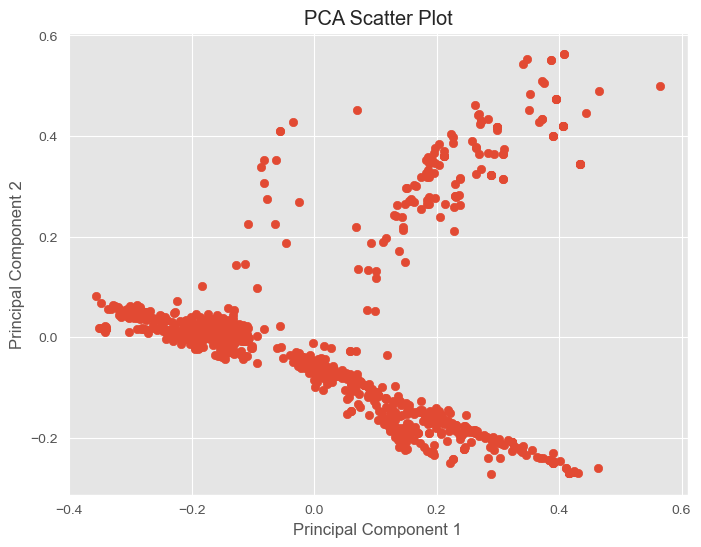

In [52]:
# Plot 
plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot')
plt.show()

## T-sne visualization for TF-IDF

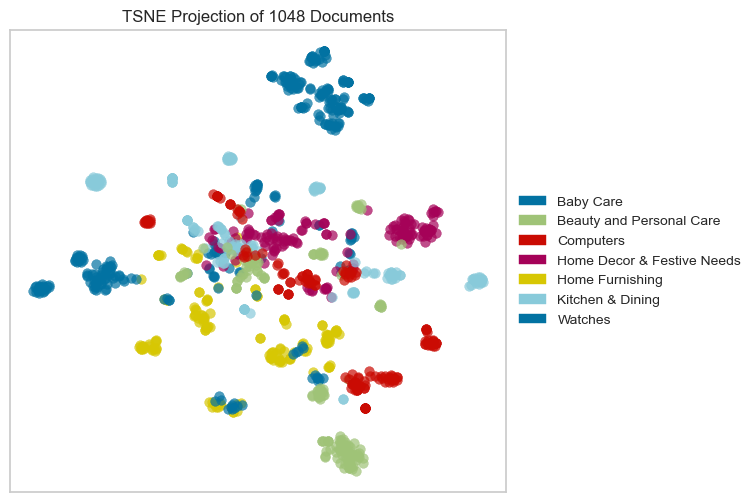

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.text import TSNEVisualizer


# Load the data and create document vectors
corpus = df_t.lemmatize_joined
tfidf = TfidfVectorizer()

X = tfidf.fit_transform(corpus)
y = df_t.category

# Create the visualizer and draw the vectors
plt.figure(figsize=(8, 6))
tsne = TSNEVisualizer()
tsne.fit(X, y)
tsne.show();

## Kmeans clustering et représentation visuelle du T-sne avec TF-ID

In [54]:
from sklearn.cluster import KMeans

In [55]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_t.lemmatize_joined)

In [56]:
num_clusters = 7  # Set the desired number of clusters
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)

# Assign cluster labels to incidents
cluster_labels = kmeans.labels_


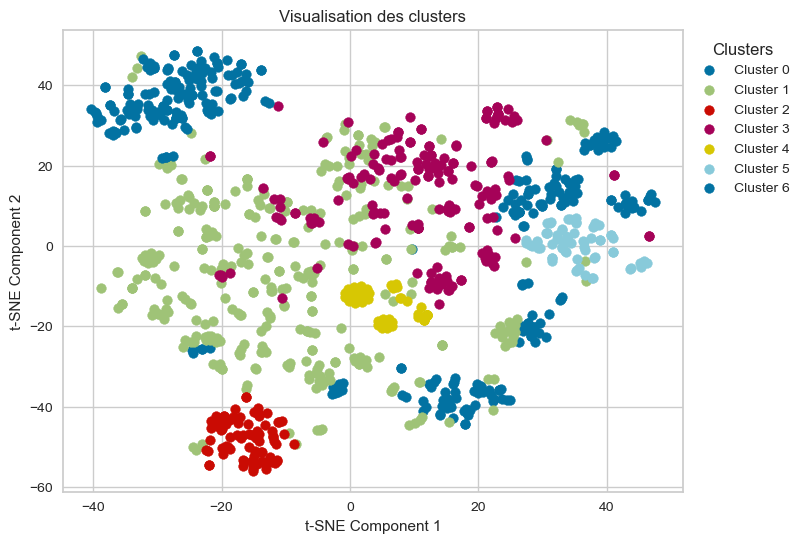

In [57]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

# Visualize clusters
plt.figure(figsize=(8, 6))
for i in range(num_clusters):
    plt.scatter(
        X_tsne[cluster_labels == i, 0],
        X_tsne[cluster_labels == i, 1],
        label=f"Cluster {i}",
    )
plt.title("Visualisation des clusters")
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title='Clusters')
plt.show()

#### ARI score of categories vs  clusters 

In [58]:
ari = adjusted_rand_score(df['category'], cluster_labels)

print("Adjusted Rand Score:", ari)

Adjusted Rand Score: 0.26939617225469603


## Word2Vec

In [59]:
from gensim.models import Word2Vec
import gensim
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings 
warnings.filterwarnings(action='ignore')

In [60]:
# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'category' column
df_t['category_encoded'] = label_encoder.fit_transform(df_t['category'])


In [61]:
model1 = gensim.models.Word2Vec(df_t.lemmatize_joined, min_count=1,
                                vector_size=100, window=5)

In [62]:
# Creating a list of sentences from df_image['lemmatized']
sentences = df_t.lemmatize_joined.tolist()

# Training the Word2Vec model
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Empty list to store sentence vectors
sentence_vectors = []

# Iterating through each sentence
for sentence in sentences:
    sentence_vector = []
    # Iterating through each word in the sentence and getting its vector
    for word in sentence:
        if word in model.wv:
            sentence_vector.append(model.wv[word])
    # Calculating the mean vector of the sentence
    if sentence_vector:
        mean_vector = np.mean(sentence_vector, axis=0)
        sentence_vectors.append(mean_vector)

# Creating a DataFrame from the sentence vectors
df_sentence_vectors = pd.DataFrame(sentence_vectors, index=df_t['lemmatize_joined'], columns=[f'feature_{i+1}' for i in range(100)])


In [63]:
len(df_sentence_vectors)

1048

In [64]:
# Defining the t-SNE 
n_components = 2
tsne = TSNE(n_components = n_components)

# Fitting to the word_vectors_df
tsne_result_wv = tsne.fit_transform(df_sentence_vectors)

# Create a new DataFrame for the t-SNE results
df_tsne_wv = pd.DataFrame(data = tsne_result_wv, columns = ["TSNE{}".format(i+1) for i in range(n_components)])

In [65]:
df_tsne_wv

TSNE1      TSNE2
0     15.427285 -16.841471
1     33.367989  24.263966
2     13.132982   8.933342
3     28.978350  24.146338
4     16.703606  25.465672
...         ...        ...
1043   8.979856  -4.928525
1044  -2.666364  11.289803
1045 -25.330034 -14.722996
1046 -23.710758  -4.891447
1047 -31.914242 -14.438671

[1048 rows x 2 columns]

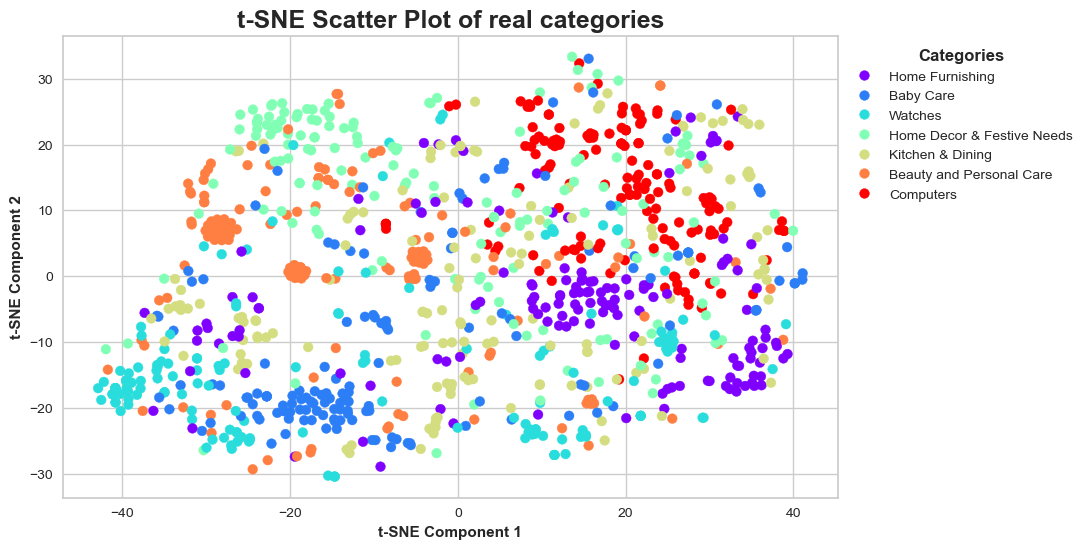

In [66]:
# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_tsne_wv['TSNE1'], df_tsne_wv['TSNE2'], c=df_t['category_encoded'], cmap='rainbow')

# Adding a legend based on the 'category' column
handles, labels = scatter.legend_elements()
legend = plt.legend(handles, df_t['category'].unique(), title='Categories', bbox_to_anchor=(1,1), loc='upper left')
legend.get_title().set_fontweight('bold')

# Adding details 
plt.xlabel('t-SNE Component 1', fontweight = 'bold')
plt.ylabel('t-SNE Component 2', fontweight = 'bold')
plt.title('t-SNE Scatter Plot of real categories', fontweight ='bold', fontsize=18)
plt.show()

### Kmeans clustering and visual representation of the T-sne on Word2Vec 

In [68]:
# kMeans on the t-SNE components
n_clusters = 7  
kmeans = KMeans(n_clusters = n_clusters)
kmeans.fit(df_tsne_wv[['TSNE1', 'TSNE2']])

# Retrieve cluster labels 
cluster_labels_wv = kmeans.labels_

# Converting to df
df_tsne_wv['Cluster'] = cluster_labels_wv

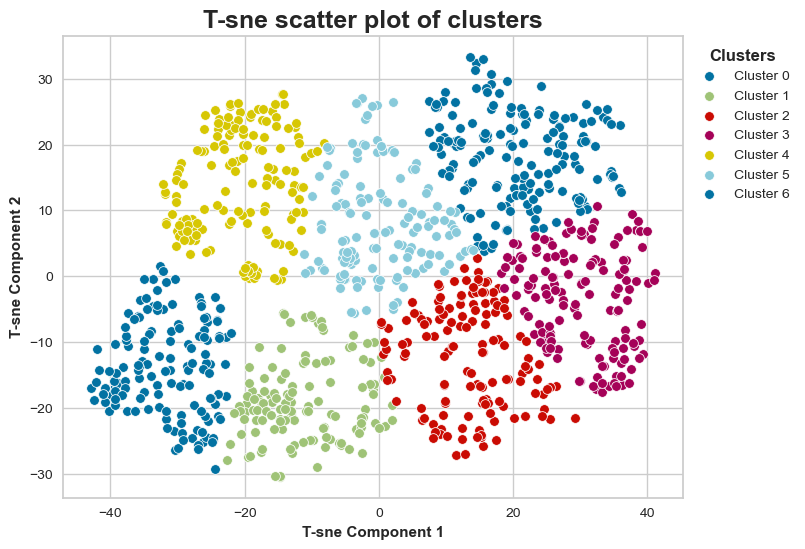

In [70]:
# Plot with a different color for each cluster 
#colors = random_colors(7) # Randomly selects 7 colors for the graph 

plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(cluster_labels_wv)):
    cluster_indices = np.where(cluster_labels_wv == label)
    sns.scatterplot(data=df_tsne_wv.loc[cluster_indices], x='TSNE1', y='TSNE2', label=f'Cluster {label}')

# Adding details 
plt.xlabel('T-sne Component 1', fontweight ='bold')
plt.ylabel('T-sne Component 2', fontweight ='bold')
plt.title('T-sne scatter plot of clusters', fontweight ='bold', fontsize=18)

# Moving the legend outside of the graph
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title='Clusters')
legend = plt.gca().get_legend()
legend.get_title().set_fontweight('bold')

plt.show()

#### ARI score of categories vs  clusters 

In [71]:
ari = adjusted_rand_score(df_t['category'], cluster_labels_wv)

print("Adjusted Rand Score:", ari)

Adjusted Rand Score: 0.14607665348135435


## BERT 

In [101]:
import torch

In [102]:
# Setting the device to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Setting the model to evaluation mode
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [103]:
# Function to encode the text using the tokenizer
def get_bert_embeddings(text):
    encoded_input = tokenizer(text, padding = True, truncation = True, return_tensors = 'pt')
    input_ids = encoded_input['input_ids'].to(device)
    attention_mask = encoded_input['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask = attention_mask)
        
    # Calculating the mean embedding of the last hidden state
    embeddings = outputs.last_hidden_state.mean(dim = 1)
    
    # Converting the embeddings to a list and return
    return embeddings.tolist()[0]

In [104]:
# Applying the function to the lemmatized text
df_bert = df_t['lemmatize_joined'].apply(get_bert_embeddings)

In [105]:
# Transforming to df
df_bert_fin = pd.DataFrame(df_bert)

In [106]:
df_bert_fin

lemmatize_joined
0     [0.04804511368274689, 0.046610839664936066, 0....
1     [0.18314212560653687, -0.02782324329018593, 0....
2     [0.007824835367500782, 0.0022673725616186857, ...
3     [0.18816757202148438, -0.03589947521686554, 0....
4     [0.25443196296691895, 0.02988302707672119, 0.6...
...                                                 ...
1045  [-0.12494365870952606, 0.2245059758424759, 0.5...
1046  [-0.3881279528141022, 0.0947309136390686, 0.59...
1047  [0.19897940754890442, -0.1123645231127739, 0.4...
1048  [0.05565405637025833, -0.03943667933344841, 0....
1049  [0.31644120812416077, -0.24362196028232574, 0....

[1048 rows x 1 columns]

In [108]:
# Transforming to a list
df_bert_list = pd.DataFrame(df_bert_fin['lemmatize_joined'].to_list())

# Splitting the values within the columns using comma delimiter
df_bert_conc = pd.concat([df_bert_list[col].astype(str).str.split(',', expand=True) for col in df_bert_list.columns], axis=1)

# Renaming columns starting from 0
df_bert_conc.columns = [str(i) for i in range(len(df_bert_conc.columns))]

# Displaying the resulting DataFrame with separate columns
df_bert_conc

0                      1                    2  \
0      0.04804511368274689   0.046610839664936066   0.7873408198356628   
1      0.18314212560653687   -0.02782324329018593   0.5348010063171387   
2     0.007824835367500782  0.0022673725616186857   0.5762696266174316   
3      0.18816757202148438   -0.03589947521686554   0.7175165414810181   
4      0.25443196296691895    0.02988302707672119   0.6154786348342896   
...                    ...                    ...                  ...   
1043  -0.12494365870952606     0.2245059758424759   0.5290270447731018   
1044   -0.3881279528141022     0.0947309136390686   0.5905271768569946   
1045   0.19897940754890442    -0.1123645231127739  0.43280264735221863   
1046   0.05565405637025833   -0.03943667933344841  0.44159039855003357   
1047   0.31644120812416077   -0.24362196028232574   0.6635656952857971   

                         3                    4                     5  \
0     -0.12329040467739105   0.4309496283531189  0.007683826144784689   
1      0.12005120515823364  0.19718357920646667  0.005752130411565304   
2     -0.03653585910797119  0.31263652443885803  -0.00377508532255888   
3      0.03351376950740814   0.3220038115978241  -0.23248618841171265   
4     -0.08420141041278839   0.3025406301021576  -0.18655537068843842   
...                    ...                  ...                   ...   
1043  -0.24495460093021393   0.5421457290649414  -0.25958842039108276   
1044  -0.09127460420131683  0.43021684885025024   -0.2671785354614258   
1045   0.08352876454591751  0.35356226563453674  -0.21194355189800262   
1046   0.12322184443473816  0.26278361678123474  -0.27610570192337036   
1047   0.17247506976127625  0.30392321944236755  -0.14077459275722504   

                          6                       7                      8  \
0       0.09294295310974121      0.0586133636534214  -0.019880129024386406   
1        0.1744929552078247  -0.0077481321059167385    -0.1438332498073578   
2      -0.10784756392240524      0.1831032633781433   -0.13834963738918304   
3      -0.08416551351547241     0.20604532957077026   -0.05749811232089996   
4     -0.017988743260502815      0.2989371120929718    0.06491528451442719   
...                     ...                     ...                    ...   
1043    0.07284571975469589      0.1775914877653122    0.11515384167432785   
1044    0.07687202841043472     0.23494316637516022     0.2785288393497467   
1045    -0.1824338734149933      0.5244327187538147   -0.18345008790493011   
1046  -0.008135638199746609     0.28833839297294617    0.08566761016845703   
1047  -0.049273014068603516      0.5287325382232666   -0.09889952093362808   

                           9  ...                    758  \
0        -0.3061487674713135  ...   -0.02509152516722679   
1       -0.16580861806869507  ...  -0.037798408418893814   
2       -0.27761560678482056  ...   -0.13666260242462158   
3     -0.0063233403488993645  ...    0.10812373459339142   
4       -0.11216564476490021  ...    0.07192430645227432   
...                      ...  ...                    ...   
1043    -0.20280544459819794  ...   -0.35391008853912354   
1044    -0.13544827699661255  ...   -0.19953598082065582   
1045   -0.042359355837106705  ...  0.0016245096921920776   
1046     -0.1690397560596466  ...     0.0157596617937088   
1047    -0.25383737683296204  ...     0.1379115879535675   

                       759                   760                   761  \
0      -0.4458596706390381   0.09960231184959412   0.12727144360542297   
1      -0.1241784542798996   0.09746749699115753  -0.02511741779744625   
2     -0.23302115499973297   0.14451773464679718  0.044191040098667145   
3     -0.14715039730072021   0.13632744550704956  -0.09044045209884644   
4     -0.24966850876808167   0.19995726644992828  0.020121267065405846   
...                    ...                   ...                   ...   
1043  -0.39847052097320557  0.029629714787006378   0.25875604152679443   
1044   -0

### T-sne on BERT 

In [109]:
# Defining the t-SNE 
n_components = 2
tsne = TSNE(n_components = n_components)

# Fitting to the df_tfidf
tsne_result_bert = tsne.fit_transform(df_bert_conc)

# Creating a new df for the results
df_tsne_bert = pd.DataFrame(data = tsne_result_bert, columns = ["TSNE{}".format(i+1) for i in range(n_components)])

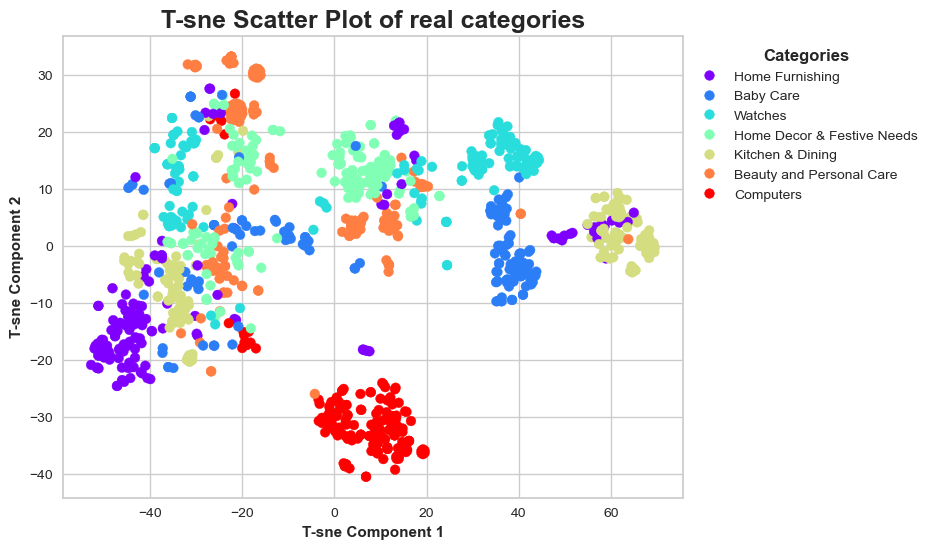

In [132]:
# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_tsne_bert['TSNE1'], df_tsne_bert['TSNE2'], c=df_t['category_encoded'], cmap='rainbow')

# Adding a legend based on the 'category' column
handles, labels = scatter.legend_elements()
legend = plt.legend(handles, df_t['category'].unique(), title='Categories', bbox_to_anchor=(1,1), loc='upper left')
legend.get_title().set_fontweight('bold')

# Adding details 
plt.xlabel('T-sne Component 1', fontweight = 'bold')
plt.ylabel('T-sne Component 2', fontweight = 'bold')
plt.title('T-sne Scatter Plot of real categories', fontweight ='bold', fontsize=18)
plt.show()

### Kmeans clustering and visual representation of the t-SNE on BERT

In [111]:
# kMeans on the t-SNE components
n_clusters = 7  
kmeans = KMeans(n_clusters = n_clusters)
kmeans.fit(df_tsne_bert[['TSNE1', 'TSNE2']])

# Retrieving cluster labels 
cluster_labels_bert = kmeans.labels_

# Converting to df
df_tsne_bert['Cluster'] = cluster_labels_bert

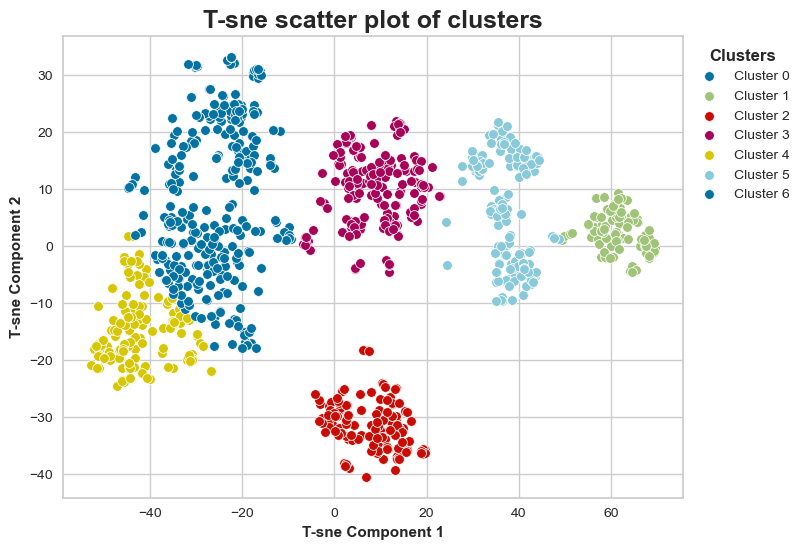

In [131]:
# Plot with a different color for each cluster 

plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(cluster_labels_bert)):
    cluster_indices = np.where(cluster_labels_bert == label)
    sns.scatterplot(data=df_tsne_bert.loc[cluster_indices], x='TSNE1', y='TSNE2', label=f'Cluster {label}')

# Adding details 
plt.xlabel('T-sne Component 1', fontweight ='bold')
plt.ylabel('T-sne Component 2', fontweight ='bold')
plt.title('T-sne scatter plot of clusters', fontweight ='bold', fontsize=18)

# Moving the legend outside of the graph
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title='Clusters')
legend = plt.gca().get_legend()
legend.get_title().set_fontweight('bold')

plt.show()

#### ARI scores of real categories vs clusters 

In [114]:
ari = adjusted_rand_score(df_t['category'], cluster_labels_bert)

print("Adjusted Rand Score:", ari)

Adjusted Rand Score: 0.31779734281214445


### USE (Universal Sentence Encoder)

In [119]:
#Converting each sequence of words into a single string
sentences = df_t['lemmatize_joined'].apply(' '.join).values.astype('U')

# Getting and loading the URL for the USE model
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5"
use_model = hub.load(module_url)

# Creating a KerasLayer fro mthe loaded model
embedding_fn = hub.KerasLayer(use_model, input_shape=[], dtype=tf.string, trainable=False)

# Creating a sequential model with the embedding layer
embedding_model = tf.keras.Sequential([embedding_fn])

# Converting the sentences to a numpy array
sentences_array = np.array(sentences, dtype=object) 

# Generating the sentences with the embedding model
embeddings = embedding_model.predict(sentences_array)

# Transforming to df
embedding_df = pd.DataFrame(embeddings)

33/33 [==============================] - 1471s 45s/step


In [120]:
embedding_df

0         1         2         3         4         5         6    \
0    -0.033529  0.005593 -0.033619 -0.019755  0.031313  0.052536 -0.018704   
1    -0.032931 -0.014672 -0.022670  0.030195  0.019436  0.043736 -0.004194   
2    -0.038978 -0.002425 -0.021920 -0.014565  0.032739  0.053969 -0.021076   
3    -0.032347 -0.016947 -0.025589 -0.010472  0.037240  0.067427 -0.020840   
4    -0.027723 -0.001744 -0.026327 -0.016045  0.038618  0.072632 -0.014721   
...        ...       ...       ...       ...       ...       ...       ...   
1043 -0.032282  0.006135 -0.029129 -0.020111  0.016617  0.051452 -0.035046   
1044 -0.036440  0.002581 -0.026254 -0.027388  0.025824  0.045920 -0.018971   
1045 -0.038190  0.007773 -0.019618  0.034748 -0.003226  0.021599 -0.014132   
1046 -0.024200  0.000890 -0.022662  0.031434 -0.007697  0.011863 -0.000972   
1047 -0.027466  0.005378 -0.014284  0.026732 -0.020965  0.011845 -0.013199   

           7         8         9    ...       502       503       504  \
0    -0.045935  0.049436  0.006521  ... -0.004326  0.051562  0.043402   
1    -0.075259  0.032070  0.010786  ... -0.012312  0.008845  0.030894   
2    -0.048443  0.039901  0.009252  ...  0.000215  0.041267  0.047461   
3    -0.054699  0.034560  0.015550  ...  0.000262  0.026612  0.044138   
4    -0.045618  0.042509  0.016353  ... -0.000673  0.040620  0.049864   
...        ...       ...       ...  ...       ...       ...       ...   
1043 -0.048416  0.041442  0.010120  ... -0.011877  0.062242  0.045373   
1044 -0.043861  0.036792  0.005104  ... -0.006930  0.047469  0.045476   
1045 -0.063171  0.017169  0.001429  ... -0.022366 -0.009080  0.023328   
1046 -0.059537  0.012374 -0.009132  ... -0.036260 -0.010704  0.028996   
1047 -0.050695 -0.000427 -0.009956  ... -0.031735  0.004240  0.021118   

           505       506       507       508       509       510       511  
0     0.026941 -0.026880 -0.121074  0.035770  0.030475  0.007476  0.024988  
1    -0.015897 -0.045434 -0.107823  0.021592  0.024653  0.018462  0.021780  
2     0.023206 -0.029807 -0.113523  0.036356  0.034544  0.004563  0.015400  
3     0.010537 -0.039083 -0.118177  0.039734  0.032643 -0.001159  0.022624  
4     0.019722 -0.031806 -0.114381  0.038945  0.036833 -0.001436  0.024166  
...        ...       ...       ...       ...       ...       ...       ...  
1043  0.023506 -0.029913 -0.113927  0.036121  0.032095  0.001256  0.032049  
1044  0.026839 -0.027651 -0.125578  0.035495  0.033867  0.012300  0.014856  
1045 -0.009145 -0.065563 -0.089140  0.009566  0.000837  0.022488  0.011840  
1046 -0.013810 -0.061179 -0.102083  0.016745  0.018931  0.031388  0.003283  
1047 -0.005544 -0.053923 -0.090498  0.014506  0.012566  0.019303  0.005789  

[1048 rows x 512 columns]

#### t-SNE on USE 

In [121]:
# Defining the t-SNE 
n_components = 2
tsne = TSNE(n_components = n_components)

# Fitting to the df_tfidf
tsne_result_use = tsne.fit_transform(embedding_df)

# Create a new DataFrame for the t-SNE results
df_tsne_use = pd.DataFrame(data = tsne_result_use, columns = ["TSNE{}".format(i+1) for i in range(n_components)])

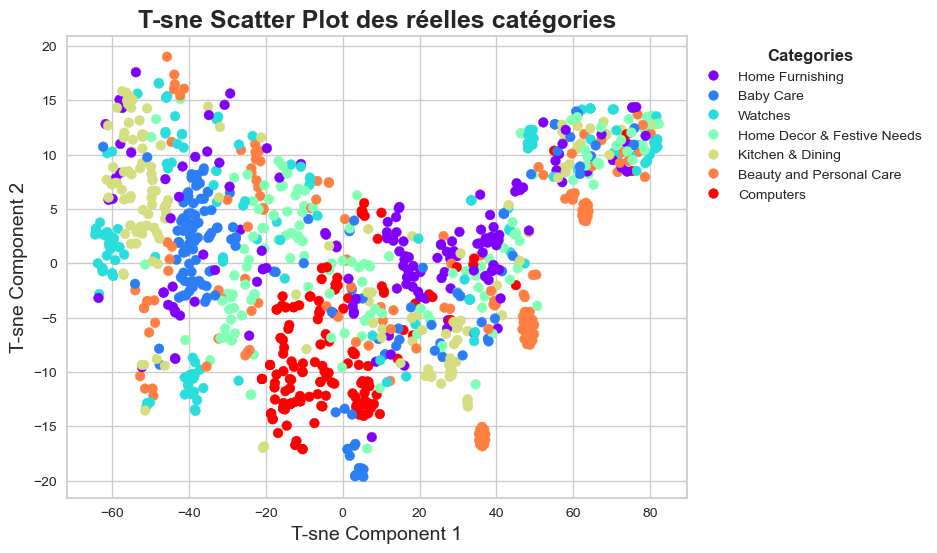

In [129]:
# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_tsne_use['TSNE1'], df_tsne_use['TSNE2'], c=df_t['category_encoded'], cmap='rainbow')

# Adding a legend based on the 'category' column
handles, labels = scatter.legend_elements()
legend = plt.legend(handles, df_t['category'].unique(), title='Categories', bbox_to_anchor=(1,1), loc='upper left')
legend.get_title().set_fontweight('bold')

# Adding details 
plt.xlabel('T-sne Component 1', fontsize=14)
plt.ylabel('T-sne Component 2', fontsize=14)
plt.title('T-sne Scatter Plot des réelles catégories', fontweight ='bold', fontsize=18)
plt.show()

### Kmeans clustering and visual representation of the t-SNE on USE

In [123]:
# kMeans on the t-SNE components
n_clusters = 7  
kmeans = KMeans(n_clusters = n_clusters)
kmeans.fit(df_tsne_use[['TSNE1', 'TSNE2']])

# Retrieve cluster labels 
cluster_labels_use = kmeans.labels_

# Converting to df
df_tsne_use['Cluster'] = cluster_labels_use

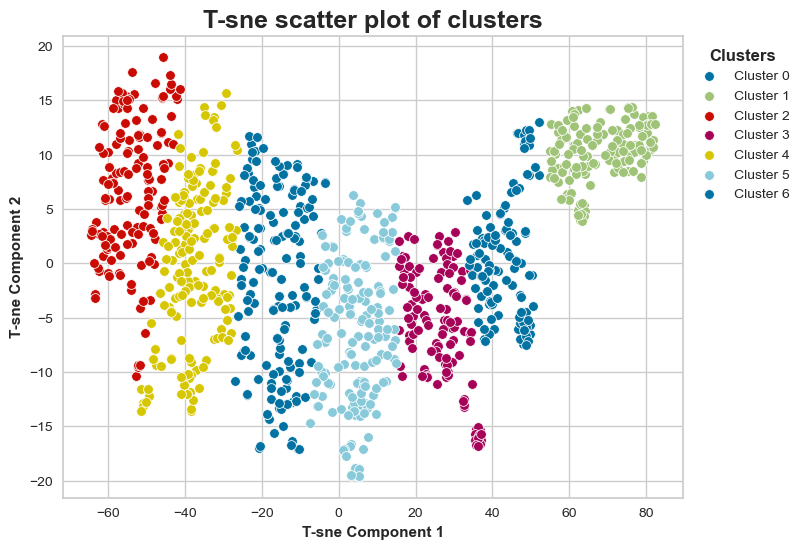

In [130]:
# Plot with a different color for each cluster 


plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(cluster_labels_use)):
    cluster_indices = np.where(cluster_labels_use == label)
    sns.scatterplot(data=df_tsne_use.loc[cluster_indices], x='TSNE1', y='TSNE2', label=f'Cluster {label}')

# Adding details 
plt.xlabel('T-sne Component 1', fontweight ='bold')
plt.ylabel('T-sne Component 2', fontweight ='bold')
plt.title('T-sne scatter plot of clusters', fontweight ='bold', fontsize=18)

# Moving the legend outside of the graph
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title='Clusters')
legend = plt.gca().get_legend()
legend.get_title().set_fontweight('bold')

plt.show()

#### ARI score of categories vs clusters 

In [126]:
ari = adjusted_rand_score(df_t['category'], cluster_labels_use)

print("Adjusted Rand Score:", ari)

Adjusted Rand Score: 0.12229353061333906


# Traitement des Images

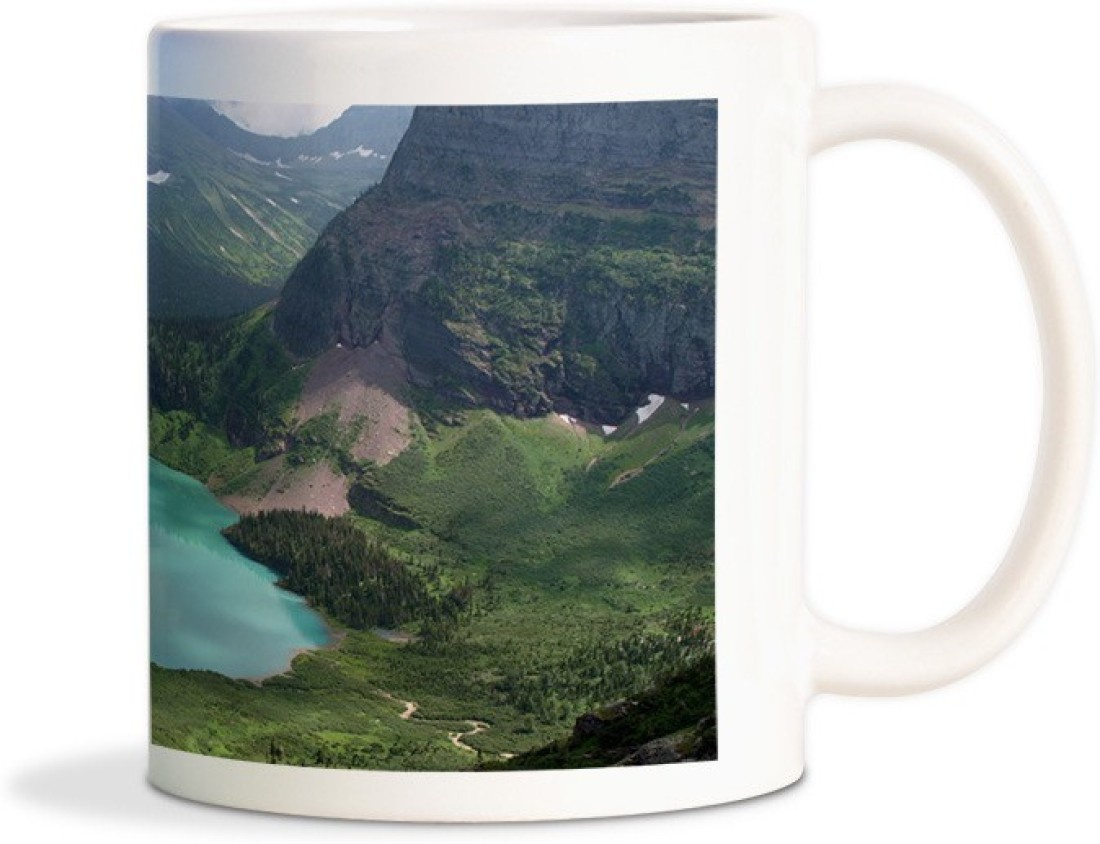

In [5]:
from IPython.display import Image
Image('Images/'+ str(df.sample(1)['image'].values.tolist()[0]), width=100 )

### Ensuite, vous analyserez le jeu de données déjà constitué en réalisant un prétraitement des images et des descriptions des produits, une réduction de dimension, puis un clustering. Les résultats du clustering seront présentés sous la forme d’une représentation en deux dimensions à déterminer, qui ’illustrera le fait que les caractéristiques extraites permettent de regrouper des produits de même catégorie. La représentation graphique vous aidera à convaincre Linda que cette approche de modélisation permettra bien de regrouper des produits de même catégorie. Attention, Linda n’a pas besoin d’un moteur de classification à ce stade, mais bien d’une étude de faisabilité

In [6]:
#Echantillon de données
img_echantillon = df.sample(50, random_state=10)
img_echantillon

uniq_id            crawl_timestamp  \
775   93618b8a998782d4d847ee5cba5c7de2  2015-12-12 11:46:53 +0000   
806   9c06a95a82c3bd6635b9fe6e92b15902  2015-12-12 11:46:53 +0000   
694   0ae859a69c7608d8197c3ba8c37bc6ec  2015-12-31 09:19:31 +0000   
370   b42a9b597a3a3dc8f428e2e2323e9aff  2015-12-01 06:13:00 +0000   
547   987e13b445c34bfedb9796d2bb78d593  2016-01-07 05:50:25 +0000   
244   0c4718ae90f2889b7021a99ee1cc106c  2015-12-01 12:40:44 +0000   
369   53c4f1e5cb1767f1a6ba05d32dfaf107  2015-12-01 06:13:00 +0000   
757   44a6d9f64668b004c3254f3904142064  2015-12-12 11:46:53 +0000   
419   e365b55f806e5d0abe0094a9f2590e33  2015-12-01 06:13:00 +0000   
1041  b1644f47c7dfa58f8c06677f2a27ee09  2015-12-01 10:15:43 +0000   
896   2eb07dc77e2fc7e3668fd7ed9b864039  2015-12-20 08:26:17 +0000   
43    2d50e4c6ccf8befe9335ac8f97a11712  2016-03-20 14:44:44 +0000   
772   8818424349b75a67775353d1feef2635  2015-12-12 11:46:53 +0000   
592   9ec6285cc619688d787d641cb87c10d6  2016-05-10 11:57:25 +0000   
109   7cbbe686c4a233e8cf53528748f75223  2016-02-25 00:26:11 +0000   
1020  6eaa9bd9e9285d77891bb76d30e6ebe7  2016-03-03 06:06:42 +0000   
786   c705a5735a94aeee547d1798e3e46ec4  2015-12-12 11:46:53 +0000   
685   6b5cdfe68595fbcab0e05dc625d3d66a  2015-12-31 09:19:31 +0000   
479   209bf06a732416f1ce5147a8b0524808  2016-01-07 05:50:25 +0000   
882   a6c820b76bc29bbe2d85eecad3de03f8  2015-12-20 08:26:17 +0000   
339   9a993e1b59649c93f667d38227325066  2015-12-01 06:13:00 +0000   
687   d61b368146f83075937e144dab93c6a1  2015-12-31 09:19:31 +0000   
629   9d3ca83f7017d6e9e129964e88503ff0  2016-06-23 23:50:58 +0000   
582   a7bd63ef1d3b345d7f9a162865bb7c0d  2016-01-07 05:50:25 +0000   
525   d21409978f5e404b53f89e444f7893fe  2016-01-07 05:50:25 +0000   
491   964648862f322b2cc153239af04b22ef  2016-01-07 05:50:25 +0000   
661   8c90f3ca64ea1a8ce104c3c3f5fc173f  2015-12-31 09:19:31 +0000   
274   c3e1435782c0929327449eec11475b96  2015-12-01 12:40:44 +0000   
918   f54d0c5cbd8e2270742293edf9075cb1  2016-01-01 13:15:34 +0000   
696   82fbc93cd45ab747e7e606f2c52c7335  2015-12-31 09:19:31 +0000   
844   2c475daafe597ed93c1e27fcaa38d8cc  2015-12-29 05:07:38 +0000   
16    5479bb7028827d60000720a2c135976a  2015-12-04 07:25:36 +0000   
428   dd5d6f0649f40d49791bbd5c00758e2f  2016-03-11 06:55:07 +0000   
153   7956d9586de3e25ff586bca58be7195e  2015-12-01 12:40:44 +0000   
514   c9531b92270ef77516d5b5b7ba2568e9  2016-01-07 05:50:25 +0000   
143   a1fd886094826c3f25c6ffb380073974  2015-12-01 12:40:44 +0000   
826   700dfd088162ea00deda33123cd7f2da  2015-12-29 05:07:38 +0000   
737   1dbe1f3ba28460dffef4a1d664549621  2016-04-13 02:13:26 +0000   
807   d0af95243e993331c4357fdf90dc4692  2015-12-12 11:46:53 +0000   
196   40829ac110f344ef35f1c8c32fb311c7  2015-12-01 12:40:44 +0000   
569   9412b6fe7b97e405def91f24f064c547  2016-01-07 05:50:25 +0000   
285   64a9d0488652194fd8e879d5e6dc8015  2016-04-24 18:34:50 +0000   
133   5531b9f454e2d75cfe00c3f795e06de5  2015-12-01 12:40:44 +0000   
475   1c0fdd598671f6f4e10b21435d766cf3  2016-04-16 13:01:18 +0000   
617   6e812fbc03331ab363789b0f2d6b3ff2  2016-03-16 23:37:14 +0000   
735   aa82b75da7579007963e53b6f818281b  2016-04-13 02:13:26 +0000   
467   0bff0eda7a6677dc1acb0477a1f7a121  2016-05-05 06:42:02 +0000   
973   798346b99002495667bb87626d33b99c  2016-06-14 18:49:44 +0000   
968   634c89325a6c7752985a74a67f985c1f  2016-05-26 12:20:35 +0000   
871   736191946aaeaa637a0865a42c18b580  2015-12-20 08:26:17 +0000   

                                            product_url  \
775   http://www.flipkart.com/carter-s-self-design-s...   
806   http://www.flipkart.com/mxofere-combo-papaya-m...   
694   http://www.flipkart.com/tallenge-christmas-col...   
370   http://www.flipkart.com/anna-andre-paris-flora...   
547   http://www.flipkart.com/maxima-01727lpln-mac-g...   
244   http://www.flipkart.com/bergner-kadhai-na-l/p/...   
369   http://www.flipkart.com/tenda-3g300m/p/itmdngv...   
757   http://www.flipkart.com/svm-navra

In [7]:
img_echantillon['image'] = img_echantillon['image'].apply(lambda x: 'Images/'+str(x))

In [8]:
img_echantillon['image'].head()

775    Images/93618b8a998782d4d847ee5cba5c7de2.jpg
806    Images/9c06a95a82c3bd6635b9fe6e92b15902.jpg
694    Images/0ae859a69c7608d8197c3ba8c37bc6ec.jpg
370    Images/b42a9b597a3a3dc8f428e2e2323e9aff.jpg
547    Images/987e13b445c34bfedb9796d2bb78d593.jpg
Name: image, dtype: object

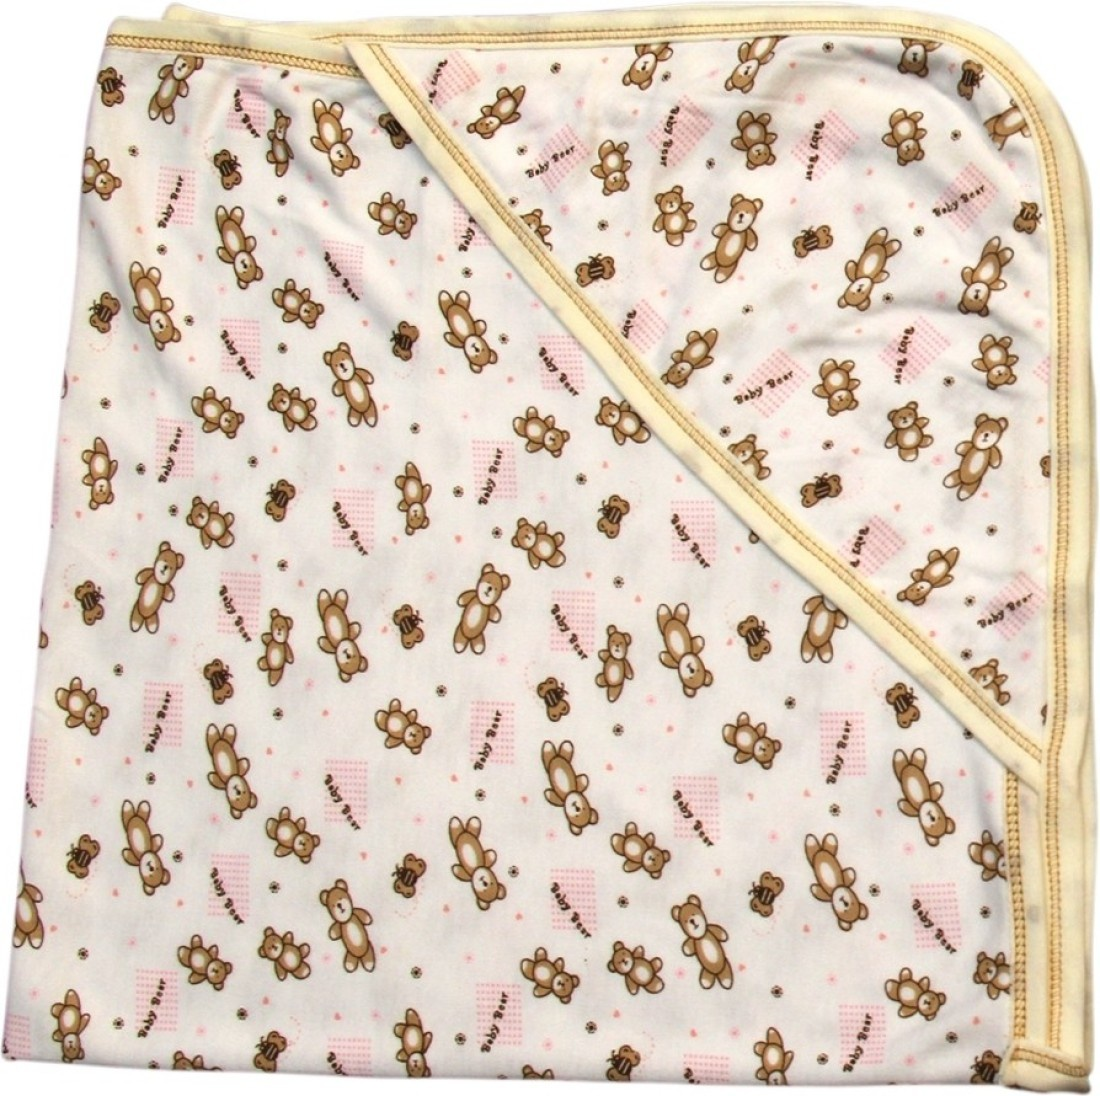

In [9]:
Image(img_echantillon.iloc[12]['image'], width=150)

In [10]:
img_echantillon.iloc[12]

uniq_id                                     8818424349b75a67775353d1feef2635
crawl_timestamp                                    2015-12-12 11:46:53 +0000
product_url                http://www.flipkart.com/offspring-printed-sing...
product_name                     Offspring Printed Single Wrapper Multicolor
product_category_tree      ["Baby Care >> Baby Bedding >> Baby Blankets >...
pid                                                         BLAE8BUKXGJ3DHMG
retail_price                                                           375.0
discounted_price                                                       290.0
image                            Images/8818424349b75a67775353d1feef2635.jpg
is_FK_Advantage_product                                                False
description                Buy Offspring Printed Single Wrapper Multicolo...
product_rating                                           No rating available
overall_rating                                           No rating available

### Préambule : essai de convolution

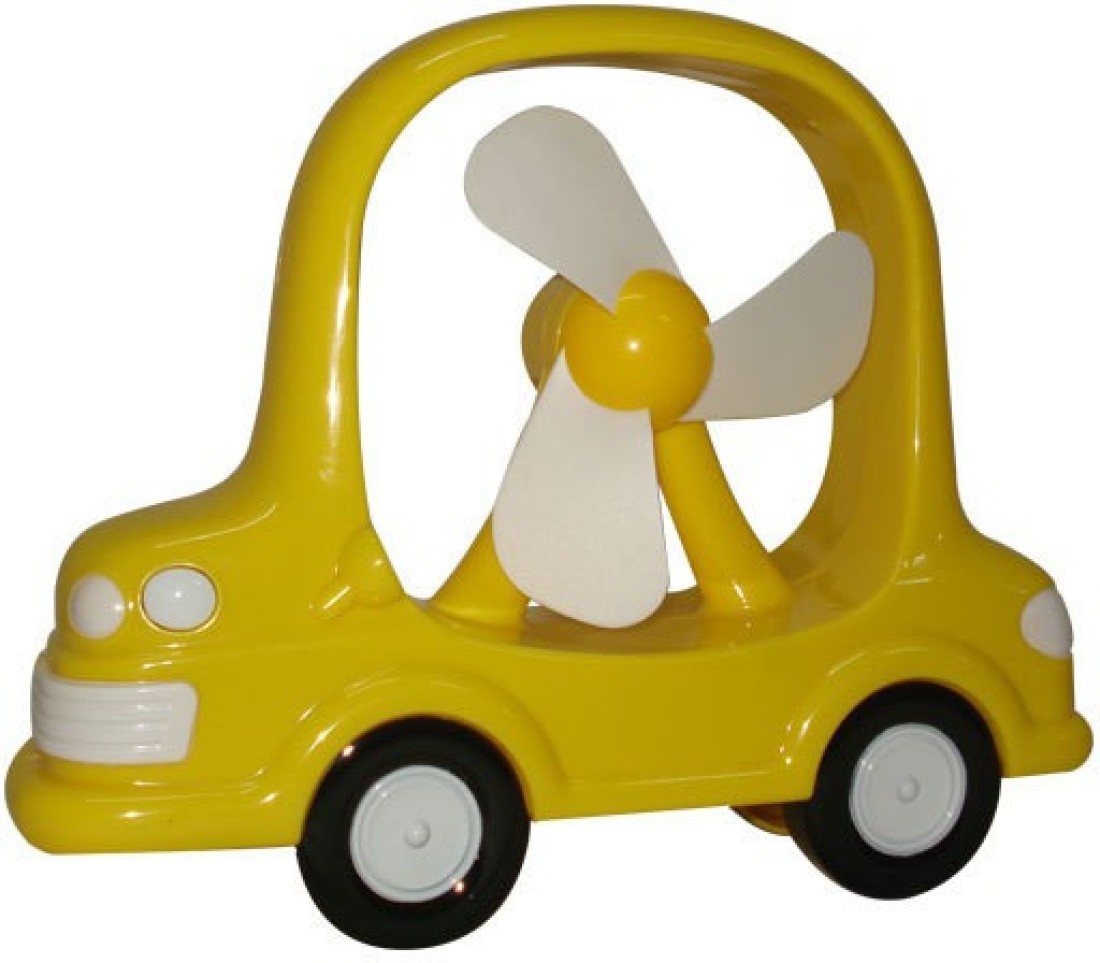

In [11]:
display(Image('Images/c612bdfa459e1e2f20d57348336c24be.jpg', width=200))

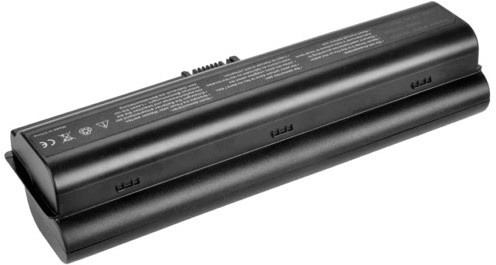

In [12]:
display(Image('Images/a8e2698d5bd4347f8136c86104ae03e3.jpg', width=200))

In [13]:
import cv2

In [14]:
from PIL import Image

img_conv = Image.open('Images//93618b8a998782d4d847ee5cba5c7de2.jpg')

In [15]:
img_conv = np.array(img_conv)

In [16]:
img_conv = cv2.resize(img_conv, (200,200))

In [17]:
def filtre_moyenneur(img, voisinage = 1):
    '''Remplace chaque pixel par l\'intensité moyenne de son voisinage'''
    etendue = 1+2*voisinage
    img2 = np.copy(img)
    
    for i in range(0, img.shape[0]):
        for j in range(0, img.shape[1]):
            if (i<voisinage)|(i>img.shape[0] - voisinage-1):
                img2[i,j] = int(255/2)
            if (j<voisinage)|(j>img.shape[0] - voisinage-1):
                img2[i,j] = int(255/2)
            
            
    for i in range(voisinage,img.shape[0]-voisinage):
        for j in range(voisinage,img.shape[1]-voisinage):
            mean = 0
            for mean_x in range(i-voisinage, i+voisinage+1):
                for mean_y in range(j-voisinage, j+voisinage+1):
                    mean += img[mean_x, mean_y]
            img2[i,j] = mean/(etendue**2)
    
    
    return img2  

In [18]:
img_conv_traitee_1 = filtre_moyenneur(cv2.cvtColor(np.array(img_conv),cv2.COLOR_BGR2GRAY), voisinage=1)
img_conv_traitee_2 = filtre_moyenneur(cv2.cvtColor(np.array(img_conv),cv2.COLOR_BGR2GRAY), voisinage=2)
img_conv_traitee_3 = filtre_moyenneur(cv2.cvtColor(np.array(img_conv),cv2.COLOR_BGR2GRAY), voisinage=3)
img_conv_traitee_4 = filtre_moyenneur(cv2.cvtColor(np.array(img_conv),cv2.COLOR_BGR2GRAY), voisinage=4)

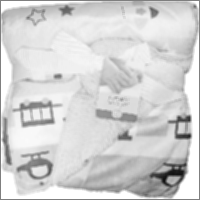

In [19]:
Image.fromarray(img_conv_traitee_1)

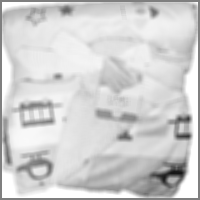

In [20]:
Image.fromarray(img_conv_traitee_2)

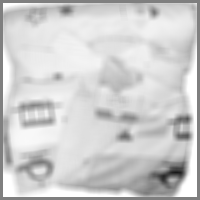

In [21]:
Image.fromarray(img_conv_traitee_3)

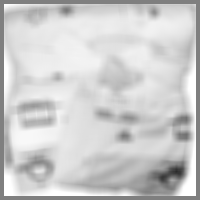

In [22]:
Image.fromarray(img_conv_traitee_4)

## Prétraitement
### Essais
### Réduction de bruit

In [23]:
from scipy.ndimage import gaussian_filter
from PIL import Image as Image_PIL

In [24]:
im = np.array(Image_PIL.open(img_echantillon.iloc[12]['image']))

In [25]:
im = gaussian_filter(im, sigma=3)

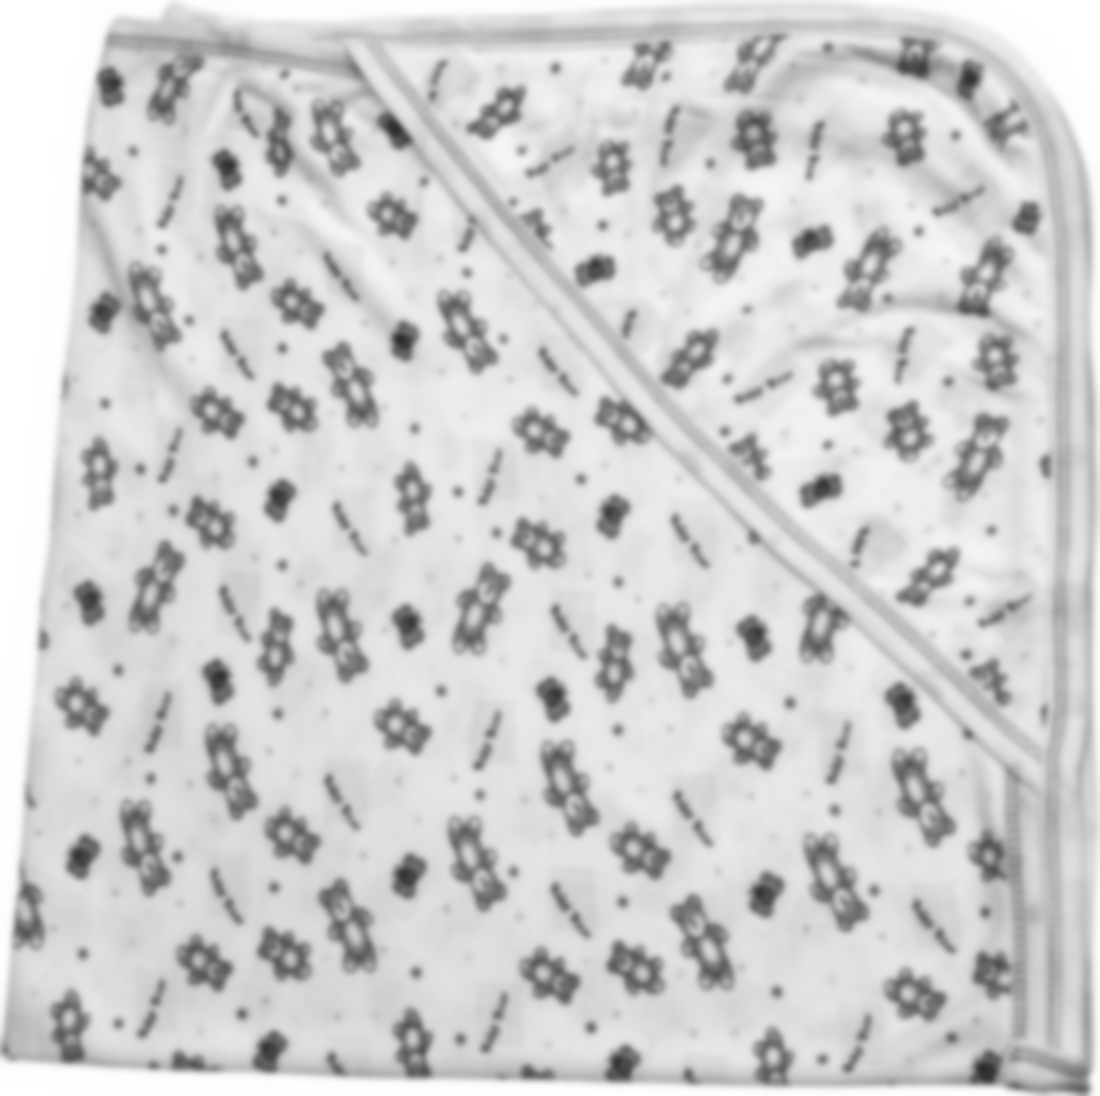

In [26]:
Image_PIL.fromarray(im)

### Egalisation

In [27]:
hist, bins = np.histogram(im.flatten(), 256, [0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

<Figure size 600x400 with 0 Axes>

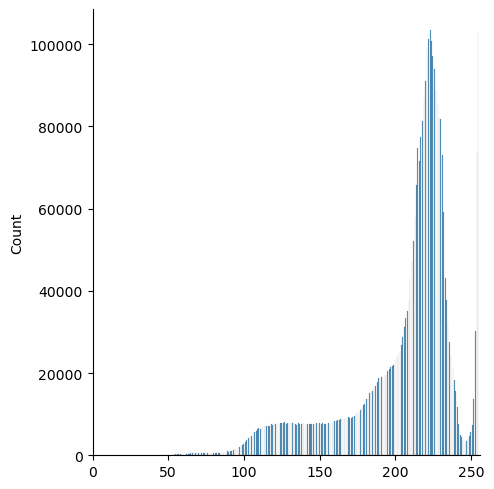

In [28]:
plt.figure(figsize=(6,4))
sns.displot(im.flatten())
plt.xlim([0,256])
plt.show();

In [29]:
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')

In [30]:
im2=cdf[im]

<Figure size 600x400 with 0 Axes>

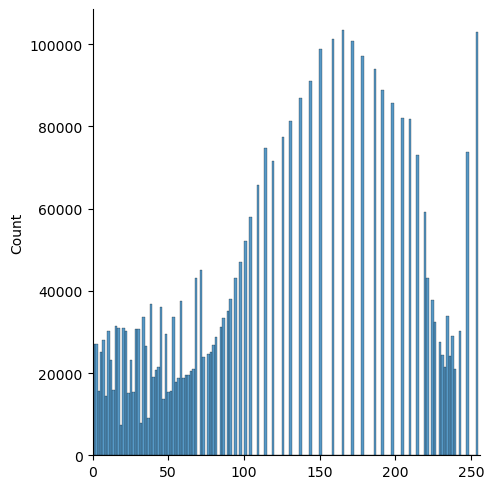

In [31]:
plt.figure(figsize=(6,4))
sns.displot(im2.flatten())
plt.xlim([0,256])
plt.show()

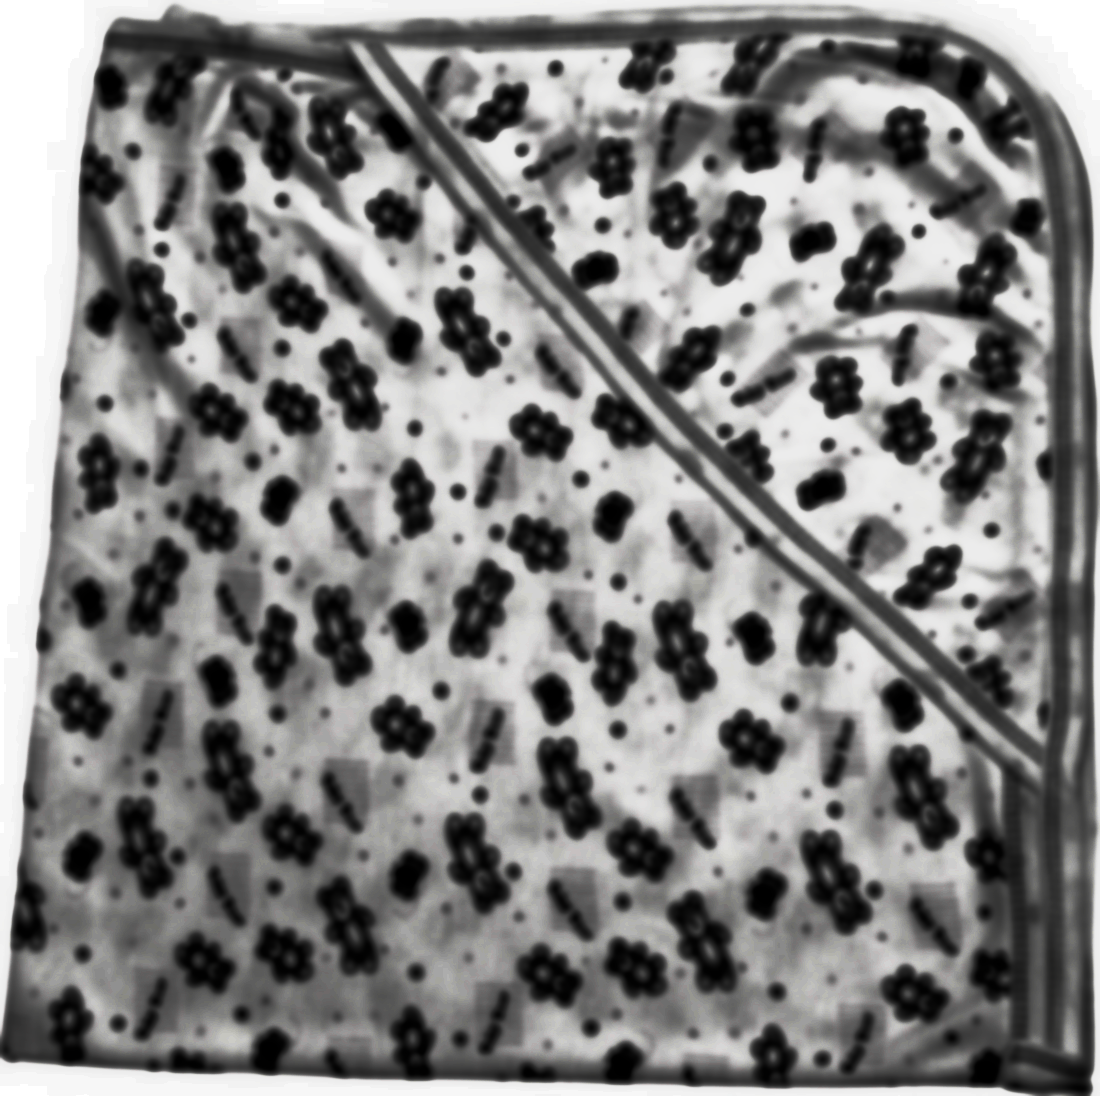

In [32]:
Image_PIL.fromarray(im2)

In [33]:
img3 = cv2.imread(img_echantillon.iloc[12]['image'],0)
equ = cv2.equalizeHist(img3)
res = np.hstack((img3,equ)) #stacking images side-by-side
cv2.imwrite('res.png',res)

True

In [34]:
img3.shape

(1096, 1100)

### Redimensionnement
#### Taille d'origine des images

In [35]:
min_x = 100000
max_x = 0
min_y = 100000
max_y = 0
for image in img_echantillon['image'].tolist():
    shape = np.array(Image_PIL.open(image)).shape
    if shape[0] < min_x:
        min_x = shape[0]
    elif shape[0] > max_x:
        max_x = shape[0]
    if shape[1] < min_y:
        min_y = shape[1]
    elif shape[1] > max_y:
        max_y = shape[1]

In [36]:
print('min_x {},\nmax_x {},\nmin_y {},\nmax_y {}'.format(min_x, max_x, min_y, max_y))

min_x 286,
max_x 4098,
min_y 302,
max_y 2800


### Redimensionnement

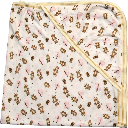

In [37]:
resize_img = cv2.resize(np.array(Image_PIL.open(img_echantillon.iloc[12]['image'])), dsize=(128,128))
Image_PIL.fromarray(resize_img)

#### Fonction de prétraitement Complète

In [38]:
def redim(array_im, width, height):
    '''Redimensionne l\'image correspondant à array_im dans la largeur et la hauteur définie'''
    min_x = 100000
    max_x = 0
    min_y = 100000
    max_y = 0
    shape = array_im.shape
    if shape[0] < min_x:
        min_x = shape[0]
    elif shape[0] > max_x:
        max_x = shape[0]
    if shape[1] < min_y:
        min_y = shape[1]
    elif shape[1] > max_y:
        max_y = shape[1]
    im = cv2.resize(array_im, dsize=(width,height))
    del shape
    return im

In [39]:
def preprocess(image, path=False):
    '''prétraitement des images:
    * filtre gaussian
    * égalisation de l'histogramme
    * redimensionnement
    prend un entrée le chemin vers l'image et en sortie la matrice np.array de l'image traitée
    '''
    #ouverture du fichier
    if path == False: #si on a fourni un array en entree :
        im = image
    else: #si on a fourni un chemin vers le fichier en entree:
        im = np.array(Image_PIL.open(image))
    
    #greyscale
    im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    
    #flou gaussien
    im = gaussian_filter(im, sigma=2)
    
    #égalisation
    im = cv2.equalizeHist(im)
    
    return redim(im, 128, 128)

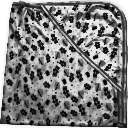

In [40]:
Image.fromarray(preprocess(img_echantillon.iloc[12]['image'], path=True))

## Extraction des caractéristiques (SIFT/ORB/SURF)
### Essais
### SIFT

In [41]:
i = np.random.randint(img_echantillon.shape[0]-1)
img_sift = preprocess(img_echantillon.iloc[12]['image'], path=True)

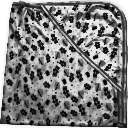

In [42]:
Image.fromarray(img_sift)

In [43]:
!pip install imutils

In [44]:
import imageio
import imutils
cv2.ocl.setUseOpenCL(False)

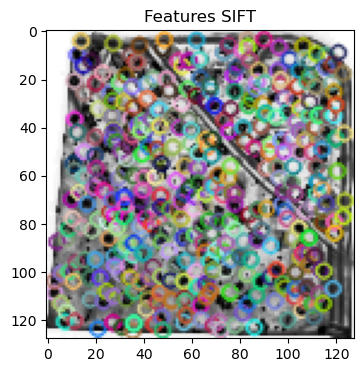

In [45]:
sift = cv2.SIFT_create()
kp = sift.detect(img_sift,None)
img=cv2.drawKeypoints(img_sift,kp,img_sift)

plt.figure(figsize=(4,4))
plt.title('Features SIFT')
plt.imshow(img)

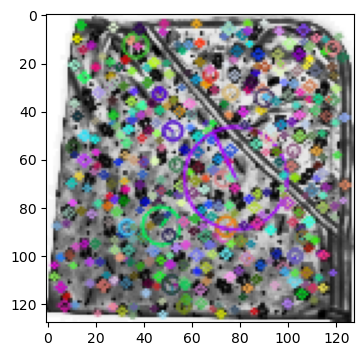

In [46]:
img=cv2.drawKeypoints(img_sift,kp,img_sift,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(4,4))
plt.imshow(img);

## ORB

In [47]:
img_orb = preprocess(img_echantillon.iloc[i]['image'], path=True)

In [48]:
orb = cv2.ORB_create()

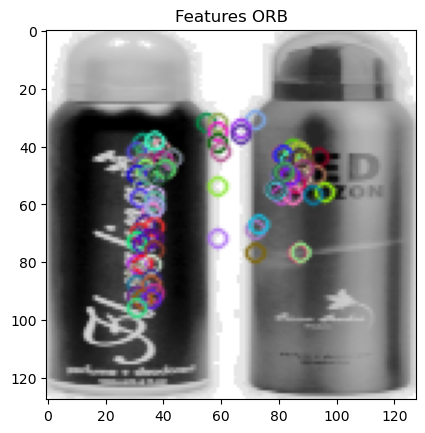

In [49]:
#find keypoints and descriptors
kp, des = orb.detectAndCompute(img_orb, mask = None)
#draw only keypoints location, not size and orientation:
image_orb = cv2.drawKeypoints(img_orb, kp, outImage = True, flags=2)
plt.title('Features ORB')
plt.imshow(image_orb)
plt.show()

In [50]:
len(kp)

84

In [51]:
des.shape

(84, 32)

In [52]:
def get_files(path_list):
    '''Renvoie la liste des matrices d\'images à partir d'une liste de chemins'''
    liste_image = []
    compteur = 0
    for image_path in path_list:
        #im = cv2.imread(image_path, 0)
        im = np.array(Image.open(image_path))
        liste_image.append(im)
        compteur +=1
    
    del compteur
    del im
    
    return liste_image

In [53]:
def redim(array_im, width, height):
    '''Redimensionne l\'image correspondant à array_im dans la largeur et la hauteur définie'''
    min_x = 100000
    max_x = 0
    min_y = 100000
    max_y = 0
    shape = array_im.shape
    if shape[0] < min_x:
        min_x = shape[0]
    elif shape[0] > max_x:
        max_x = shape[0]
    if shape[1] < min_y:
        min_y = shape[1]
    elif shape[1] > max_y:
        max_y = shape[1]
    im = cv2.resize(array_im, dsize=(width,height))
    
    del shape
    
    return im

In [54]:
df['image'] = df['image'].apply(lambda x: "/kaggle/input/dataset-flipkart/Flipkart/Images/"+str(x))


In [56]:
#train_cnn = get_files(df.copy()['image'].tolist())

In [102]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore')
array_cats = ohe.fit_transform(np.array(df_t['category']).reshape(-1,1))

In [103]:
array_cats.todense().shape

(1048, 7)

In [104]:
array_cats.shape

(1048, 7)

In [105]:
train_array_cats = ohe.transform(df_t[['category']]).todense()
test_array_cats = ohe.transform(df_t[['category']]).todense()

In [106]:
ohe.categories_

[array(['Baby Care', 'Beauty and Personal Care', 'Computers',
        'Home Decor & Festive Needs', 'Home Furnishing',
        'Kitchen & Dining', 'Watches'], dtype=object)]

In [96]:
from keras.models import clone_model

In [100]:
#from keras.preprocessing.image import load_img, img_to_array
#from keras_preprocessing.image import load_img
from keras.applications.vgg16 import preprocess_input

from tensorflow.keras.utils import load_img, img_to_array 

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Activation

In [107]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(128,128,3,)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(ohe.categories_[0].shape[0], activation='softmax'))
model.compile(loss='mean_squared_error', optimizer='sgd')

In [108]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 7)                